In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import yt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.colors import LogNorm
import os,sys

from galaxy_analysis.static_data import SOLAR_ABUNDANCE

# galaxy analysis methods (for comparison)
from galaxy_analysis.gizmo import yield_model
from galaxy_analysis.utilities import cy_convert_abundances as ca
from galaxy_analysis.plot.plot_styles import *
#--------------
import copy
#--------------
import gizmo_analysis as gizmo
import utilities as gizmo_ut
from utilities.basic.binning import BinClass

#------------------------------
input_type = 'mass'

def plot_settings():
    fsize = 21
    rc('text',usetex=False)
    rc('font',size=fsize)
    return

plot_settings()
metals = ['c','n','o','ne','mg','si','s','ca','fe']


In [4]:
simulation = 'm12q_res5700'
sim_index = 479

metals = ['c','n','o','ne','mg','si','s','ca','fe']

outdir = './' + simulation + '/'
if not os.path.isdir(outdir):
    os.mkdir(outdir)

wdir = "/home/aemerick/work/gizmo_runs/" + simulation + "/" 

initial_part = gizmo.io.Read.read_snapshots(['gas'],'index',0,simulation_directory=wdir)
initial = {}
for e in ['H','He','C','N','O','Ne','Mg','Si','S','Ca','Fe']:
    initial[str.lower(e)] = np.average(initial_part['gas'].prop('massfraction.' + str.lower(e)))
initial['metals'] = np.average(initial_part['gas'].prop('massfraction.metals'))

# load the data set
part = gizmo.io.Read.read_snapshots(['gas','star'], 'index', sim_index,
                                    assign_host_principal_axes=True, 
                                    simulation_directory = wdir)

z_solar_fire   = 0.02
z_solar_nugrid = 0.0245

z_fraction     = 0.02

if not 'nugrid' in simulation:
    FIRE2_models = {}
    FIRE2_yield_tables = {}
    fire_part = {}
    for z in [0.0001, 0.001, 0.01, 0.02]:
        fire_part[z] = copy.deepcopy(part)

        FIRE2_models[z] =  gizmo.agetracers.FIRE2_yields(model_Z = z / z_solar_fire, Z_scaling = True)
        FIRE2_yield_tables[z] =  gizmo.agetracers.construct_yield_table(FIRE2_models[z], 
                                                                        fire_part[z].ageprop.age_bins/1000.0)

        fire_part[z].set_yield_table(FIRE2_yield_tables[z], FIRE2_models[z].elements)
        fire_part[z].set_initial_abundances(initial)


# 
# These are NOT the default NuGrid arguements. These are the args Dhruv uses in generating
# the yield fields
#
if 'nugrid' in simulation:
    NuGrid_models = {}
    NuGrid_yield_tables = {}
    nugrid_part = {}

    dhruv_sygma_kwargs = {'imf_type' : 'kroupa', 'dt':1e4, 'special_timesteps':1000,
                          'ns_merger_on':True,'imf_bdys':[0.1,100.01],'tend':1.5e10,'f_binary':1.0,
                          'transitionmass':8.0,'imf_yields_range':[1,99.0]}

    for z in [0.0001,0.001,0.01,0.02]:

        nugrid_part[z] = copy.deepcopy(part)

        NuGrid_models[z] = gizmo.agetracers.NuGrid_yields(
                                        iniZ = z, **dhruv_sygma_kwargs)



        NuGrid_yield_tables[z] = gizmo.agetracers.construct_yield_table(NuGrid_models[z], 
                                                                        nugrid_part[z].ageprop.age_bins/1000.0)



        nugrid_part[z].set_yield_table(NuGrid_yield_tables[z], [str.lower(x) for x in NuGrid_models[z].elements])
        nugrid_part[z].set_initial_abundances(initial)    


# in utilities.simulation.Snapshot():
* reading:  home/aemerick/work/gizmo_runs/m12q_res5700/snapshot_times.txt

  using snapshot index = 0, redshift = 99.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/aemerick/work/gizmo_runs/m12q_res5700/output/snapshot_000.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 16220880 particles
    dark2     (id = 2): 4132251 particles
    gas       (id = 0): 16220880 particles
    star      (id = 4): 0 particles
    blackhole (id = 5): 0 particles

* reading species: ['gas']
* reading gas properties: ['acceleration', 'density', 'electron.fraction', 'hydrogen.neutral.fraction', 'id', 'id.child', 'id.generation', 'mass', 'massfraction', 'position', 'potential', 'sfr', 'smooth.length', 'temperature', 'velocity']
* reading particles from:
    home/aemerick/work/gizmo_runs/m12q_res5700/output/snapshot_000.hdf5

! cannot find MUSIC config file:  home/aemerick/work/gizmo_runs/m12q_res5700/*/*.conf
! 

In [ ]:
#
#
# Profiles (spatial)
#
#

SpeciesProfile = gizmo_ut.particle.SpeciesProfileClass(
                 scaling = 'linear', limits=[0,300], width=1,
                 dimension_number=3)

# select_dict:
select_dict = {'metallicity.fe' : (-3.8,np.inf)}

#
# Get all metal profiles for gas as a function of radius
# for both live elemnts and aagetracers
#
pro = {}

ptype = 'gas'

if ptype == 'gas':
    weight_by_mass = True
else:
    weight_by_mass = False

for name in ['metallicity','metallicity.agetracers']:
    for e in metals:
        field = name + '.' + e
        
        print(field)
        
        pro[field] = SpeciesProfile.get_statistics_profiles(fire_part[0.01], ptype, field,
                                                            property_select = select_dict,
                                                            weight_by_mass=weight_by_mass)
        
        for denom in ['fe','mg','o']:
            if e == denom:
                continue
            
            field = name + '.' + e + ' - ' + name + '.' + denom
            pro[field] = SpeciesProfile.get_statistics_profiles(fire_part[0.01], ptype, field,
                                                                property_select = select_dict,
                                                                weight_by_mass=weight_by_mass)
            

In [ ]:
plot_settings()


def plot_species_radius(outname, denom='h', plot_difference=False, abs_val = False):
    """
    Plot species as a function of radius [X/denom] in a panel plot.
    
    params: denom, string : optional name of denominator (default 'h')
    params: plot_difference, bool : optional, plot sim_val - age_val in dex (False)
    params: abs_val, bool : optional, take absolute value of above if used (False)
    
    """
    #
    # Plot metal species as a function of radius
    #
    fig, all_axes = plt.subplots(3,3,sharex=True,sharey=True)
    fig.set_size_inches(24,24)
    fig.subplots_adjust(hspace=0,wspace=0)

    ls     = {'metallicity' : '-', 'metallicity.agetracers' : '-'}

    axi=0
    axj=0
    
    for e in metals:
        axindex=(axi,axj)
        ax=all_axes[axindex]
        
        
        if e == denom:
            print("skipping ",e,denom)
            
        elif plot_difference:

            
            if denom == 'h':
                denom_field_str = ''
            else:
                denom_field_str = ' - metallicity.' + denom 
            simfield = 'metallicity.' + e + denom_field_str             
                
            simvals = pro[simfield]['gas']
                
                
            if denom == 'h':
                denom_field_str = ''
            else:
                denom_field_str = ' - metallicity.agetracers.' + denom             
            agefield = 'metallicity.agetracers.' + e + denom_field_str            
                
            agevals = pro[agefield]['gas']
            
            diff = simvals['median'] - agevals['median']
            
            if abs_val:
                diff = np.abs(diff)
            
            ax.plot(pro[simfield]['gas']['distance.mid'],
                    diff, lw = 3, color = 'black', ls = '-')
            
                    
            if axj == 0:
                ax.set_ylabel("Abundance Offset [X/" + denom + "]")    

        else:

            for k in ['metallicity','metallicity.agetracers']:

                if denom == 'h':
                    denom_field_str = ''
                else:
                    denom_field_str = ' - ' + k + '.' + denom

                field = k + '.' + e + denom_field_str

                if 'agetracer' in k:
                    label = None
                    color = 'C0'
                    fbcolor = 'C0'
                else:
                    label = e
                    color = 'black'
                    fbcolor = 'black'


                ax.plot(pro[field]['gas']['distance.mid'], pro[field]['gas']['median'], lw = 3, ls = ls[k],
                        color = color, label = label)

                ax.fill_between(pro[field]['gas']['distance.mid'], 
                                pro[field]['gas']['percent.16'], pro[field]['gas']['percent.84'], 
                                ls = ls[k], color = fbcolor, label = label, alpha = 0.5)
                if axj == 0:
                    ax.set_ylabel("Median Abundance [X/"+denom+"]")                    

        xy = (0.05,0.05)
        ax.annotate("["+e+"/" + denom + "]", xy,xy,xycoords='axes fraction')                    
            
        if axi == 2:
            ax.set_xlabel('Distance (kpc)')
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
            

        ax.semilogx()
        if plot_difference:
            if abs_val:
                ax.set_ylim(0,0.4)
            else:
                ax.set_ylim(-.5,.5)
        else:
            ax.set_ylim(-3,1)
        ax.set_xlim(0.2,300.0)

        axj = axj+1
        if axj >= 3:
            axj = 0
            axi=axi+1


    fig.savefig(outname)
    return 


plot_species_radius("X_over_H_distance_diff.png", denom='h', plot_difference=True, abs_val=True)
plot_species_radius("X_over_Fe_distance_diff.png", denom='fe', plot_difference=True, abs_val=True)
plot_species_radius("X_over_O_distance_diff.png", denom='o', plot_difference=True, abs_val=True)

In [7]:
plot_settings()
#
#
# plot as a function of some other field
#   
# 
#

def generate_statistics(_part, xfield, xlim, denom='h', scaling = 'linear', nbins=100, select_dict=None, ptype='gas'):
    
    def _denom_field_str(_denom,_k):
        if denom == 'h':
            _d = ''
        else:
            _d = ' - ' + _k  + _denom   
        return _d   
    
    # generate the bin class object to handle binning
    bc = BinClass(xlim, number = nbins, scaling = scaling)
    
    # get particle mass for weightings
    pm = _part[ptype].prop('mass')
    
    # if selection is provided, generate selection array
    # but use dummy selection anyway to simplify code
    select = pm == pm
    if not (select_dict is None):
        for k in select_dict.keys():
            select = select * ((_part[ptype].prop(k) > select_dict[k][0])*(_part[ptype].prop(k)<select_dict[k][1]))
    

    _stats = {}
    for e in metals:  
        # generate stats - save for later
  

                      
        
        for k in ['metallicity.', 'metallicity.agetracers.']:
            
            yfield = k + e + _denom_field_str(denom,k)
            
            _stats[yfield] = bc.get_statistics_of_array(_part[ptype].prop(xfield)[select],
                                                _part[ptype].prop(yfield)[select], weights=pm[select])
            
        # now compute particle-by-particle difference between sim and agetracer abundance
        yfield = e + '_over_' + denom + '_difference'
        _stats[yfield] = bc.get_statistics_of_array( _part[ptype].prop(xfield)[select],
                                (_part[ptype].prop('metallicity.' + e + _denom_field_str(denom,'metallicity.'))[select] -\
                                _part[ptype].prop('metallicity.agetracers.' + e + _denom_field_str(denom,'metallicity.agetracers.'))[select]),
                                                        weights = pm[select])
        

             
    
    
    
    return _stats

def generate_error_distribution(_part, xlim, diff = True, absval = True, normed=True,
                                denom='h', scaling = 'linear', nbins=100, select_dict=None, ptype='gas'):
    """
    Compute the absolute error (default behavior) on a particle-by-particle basis
    for simulated abundances and age-tracer abundances
    """
    
    def _denom_field_str(_denom,_k):
        if denom == 'h':
            _d = ''
        else:
            _d = ' - ' + _k  + _denom   
        return _d   
    
    # generate the bin class object to handle binning
    bc = BinClass(xlim, number = nbins, scaling = scaling)
    bc_2 = BinClass((-4,4), number = (8/0.01)+1, scaling = scaling)
    
    
    # get particle mass for weightings
    pm = _part[ptype].prop('mass')
    
    # if selection is provided, generate selection array
    # but use dummy selection anyway to simplify code
    select = pm == pm
    if not (select_dict is None):
        for k in select_dict.keys():
            select = select * ((_part[ptype].prop(k) > select_dict[k][0])*(_part[ptype].prop(k)<select_dict[k][1]))
    

    _stats = {}
    
    if diff:
        for e in metals:  
        #
        # generate stats - save for later
        #            
            y_sim_field = 'metallicity.' + e + _denom_field_str(denom,'metallicity.')
            y_age_field = 'metallicity.agetracers.' + e + _denom_field_str(denom,'metallicity.agetracers.')
            
            y_sim = _part[ptype].prop(y_sim_field)[select]
            y_age = _part[ptype].prop(y_age_field)[select]
        
            yvals = y_sim - y_age
            if absval:
                yvals = np.abs(yvals)
                 
            yfield = e + '_over_' + denom + '_difference'                    
            _stats[yfield] = {}
            _stats[yfield]['hist_age'] = bc_2.get_distribution( y_age, weights=pm[select])
            _stats[yfield]['hist_sim'] = bc_2.get_distribution( y_sim, weights=pm[select])
            _stats[yfield]['hist'] = bc.get_distribution( yvals, normed = normed)
                
            _stats[yfield].update( {'median' : np.median(yvals), 'mean' : np.average(yvals),
             'Q1'     : np.quantile(yvals,0.25), 'Q3' : np.quantile(yvals,0.75),
             'IQR'    : np.quantile(yvals,0.75) - np.quantile(yvals,0.25),
             '96'     : np.quantile(yvals,0.96), 'D1' : np.quantile(yvals,0.1), 'D9' : np.quantile(yvals,0.9),
             'std'    : np.std(yvals), 'D9' : np.quantile(yvals,0.9), 'D1' : np.quantile(yvals,0.1) })
            
            _stats[yfield]['0.2dex']   = np.size( yvals[ np.abs(yvals) < 0.2  ]) / (1.0*np.size(yvals))
            _stats[yfield]['0.1dex']   = np.size( yvals[ np.abs(yvals) < 0.1  ]) / (1.0*np.size(yvals))
            _stats[yfield]['0.05dex']  = np.size( yvals[ np.abs(yvals) < 0.05 ]) / (1.0*np.size(yvals))
            _stats[yfield]['0.02dex']  = np.size( yvals[ np.abs(yvals) < 0.02 ]) / (1.0*np.size(yvals))
            _stats[yfield]['0.01dex']  = np.size( yvals[ np.abs(yvals) < 0.01 ]) / (1.0*np.size(yvals))
            _stats[yfield]['0.005dex'] = np.size( yvals[ np.abs(yvals) < 0.005]) / (1.0*np.size(yvals))
        
    else:
        print("diff == False not enabled yet")
        raise(RuntimeError)
    
    return _stats




In [8]:

#
# ignore these particles (filter out gas and star particles that haven't been enriched)
#
select_dict = {'gas'  : {'metallicity.o':(-3.7,np.inf)}, 
               'star' : {'metallicity.o':(-3.7,np.inf)}}

#
# generate statistics for a few fields
# this will take some time
# 
# want to know: temperature, Fe/H, density, any more?
#
# for [X/H] and ratios
#

if 'nugrid' in simulation:
    part_for_analysis = nugrid_part[0.02]
else:
    part_for_analysis = fire_part[0.001]

all_stats = {}                        
for ptype in ['star','gas']:
    
    all_stats[ptype] = {'errors': {}, 'temperature':{}, 'metallicity.fe':{}, 'number.density':{}}

    for denom in ['h','fe','o']:
        print(ptype,denom)
        all_stats[ptype]['errors'].update( generate_error_distribution(part_for_analysis, (0,3),nbins=3001,denom=denom,ptype=ptype,
                          select_dict=select_dict[ptype]) )
                     
        #continue
        
        if ptype == 'gas' or ptype == 'star':
            all_stats[ptype]['metallicity.fe'].update(generate_statistics(part_for_analysis, 'metallicity.fe', (-4.0,1.0), denom=denom, scaling = 'linear',
                                                select_dict = select_dict[ptype], ptype = ptype ))
                        
        if ptype == 'gas':                        
            all_stats[ptype]['temperature'].update( generate_statistics(part_for_analysis,'temperature', (10.0,1.0E7), denom=denom, scaling = 'log',
                                           select_dict = select_dict[ptype],ptype=ptype))

            all_stats[ptype]['number.density'].update( generate_statistics(part_for_analysis, 'number.density', (1.0E-10,3.0E3), 
                                                                    denom=denom, scaling = 'log',
                                         select_dict = select_dict[ptype], ptype = ptype) )
    

#stats.update( generate_statistics(''))

star h
star fe


/home/aemerick/code/utilities/basic/statistic.py:167: RuntimeWarning: invalid value encountered in float_scalars
  stat['average.50'] = np.sum(values[masks] * weights[masks]) / np.sum(weights[masks])
/home/aemerick/code/utilities/basic/statistic.py:167: RuntimeWarning: invalid value encountered in double_scalars
  stat['average.50'] = np.sum(values[masks] * weights[masks]) / np.sum(weights[masks])


star o
gas h

# in utilities.basic.binning.get_bin_indices():
! input value limits = [0.45, 7.43] exceed bin limits = [1.0, 7.0]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [0.45, 7.43] exceed bin limits = [1.0, 7.0]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [0.45, 7.43] exceed bin limits = [1.0, 7.0]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [0.45, 7.43] exceed bin limits = [1.0, 7.0]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [0.45, 7.43] exceed bin limits = [1.0, 7.0]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [0.45, 7.43] exceed bin limits = [1.0, 7.0]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [0.45, 7.43] exceed bin limits = [1.0, 7.0]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [0.45, 7.43] exceed bin limits = [1.0, 7.0]

# in utilities.basic.binning.get_bin_indices():
! input va

# in utilities.basic.binning.get_bin_indices():
! input value limits = [0.45, 7.43] exceed bin limits = [1.0, 7.0]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [0.45, 7.43] exceed bin limits = [1.0, 7.0]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [0.45, 7.43] exceed bin limits = [1.0, 7.0]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [0.45, 7.43] exceed bin limits = [1.0, 7.0]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [0.45, 7.43] exceed bin limits = [1.0, 7.0]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [0.45, 7.43] exceed bin limits = [1.0, 7.0]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [0.45, 7.43] exceed bin limits = [1.0, 7.0]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [0.45, 7.43] exceed bin limits = [1.0, 7.0]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [

# in utilities.basic.binning.get_bin_indices():
! input value limits = [-11.99, 3.42] exceed bin limits = [-10.0, 3.48]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [-11.99, 3.42] exceed bin limits = [-10.0, 3.48]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [-11.99, 3.42] exceed bin limits = [-10.0, 3.48]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [-11.99, 3.42] exceed bin limits = [-10.0, 3.48]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [-11.99, 3.42] exceed bin limits = [-10.0, 3.48]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [-11.99, 3.42] exceed bin limits = [-10.0, 3.48]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [-11.99, 3.42] exceed bin limits = [-10.0, 3.48]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [-11.99, 3.42] exceed bin limits = [-10.0, 3.48]

# in utilities.basic.binning.get

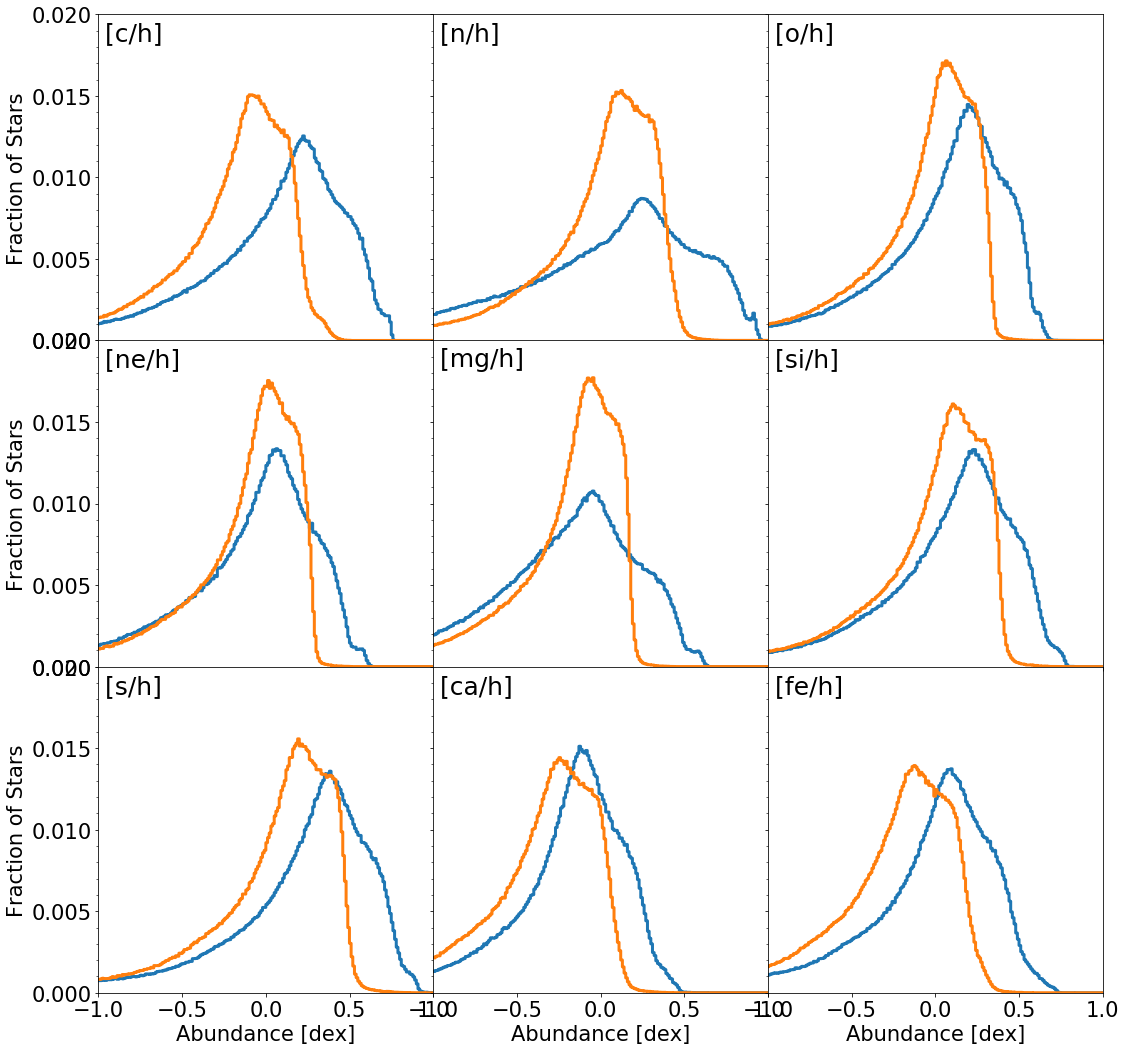

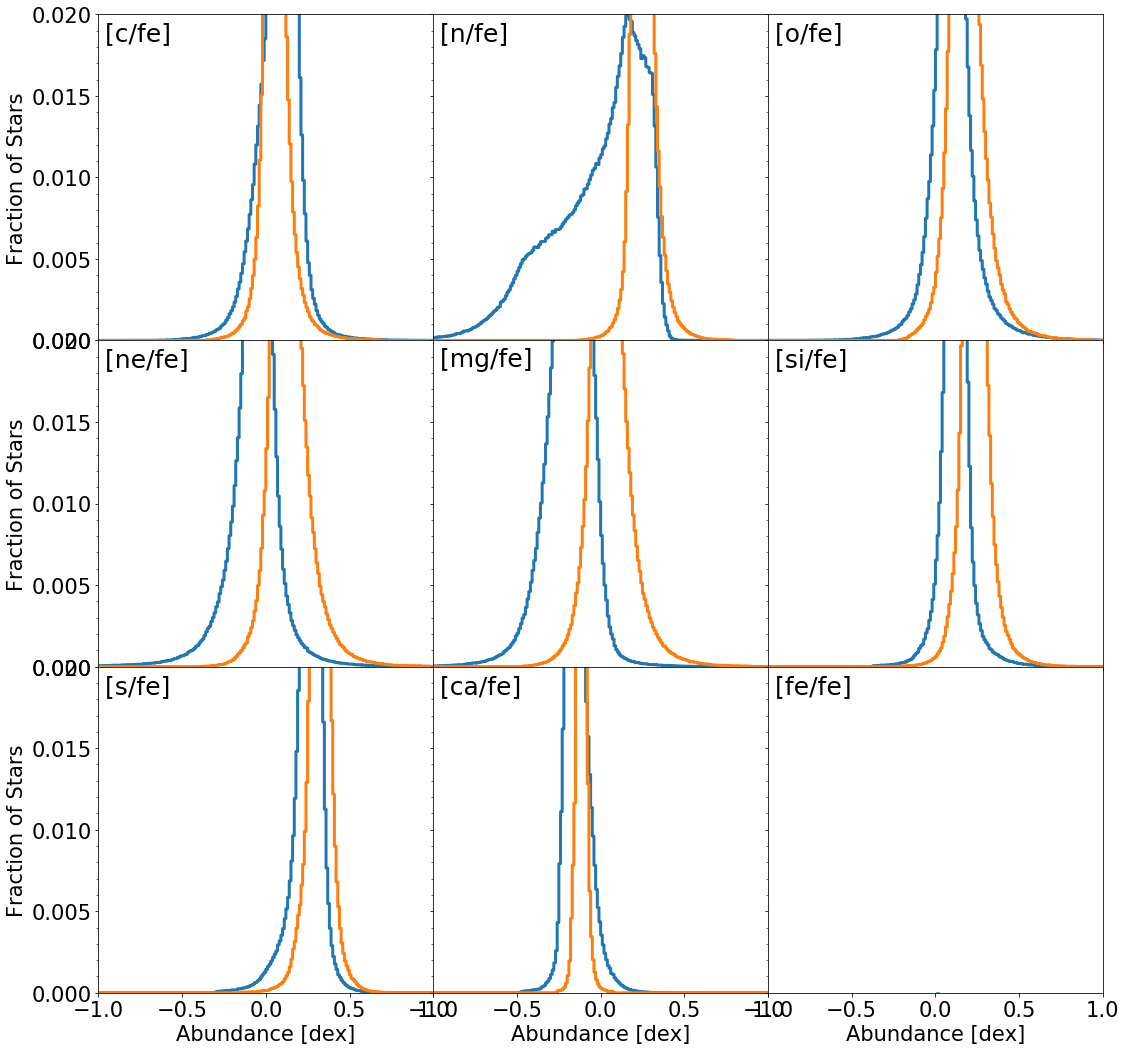

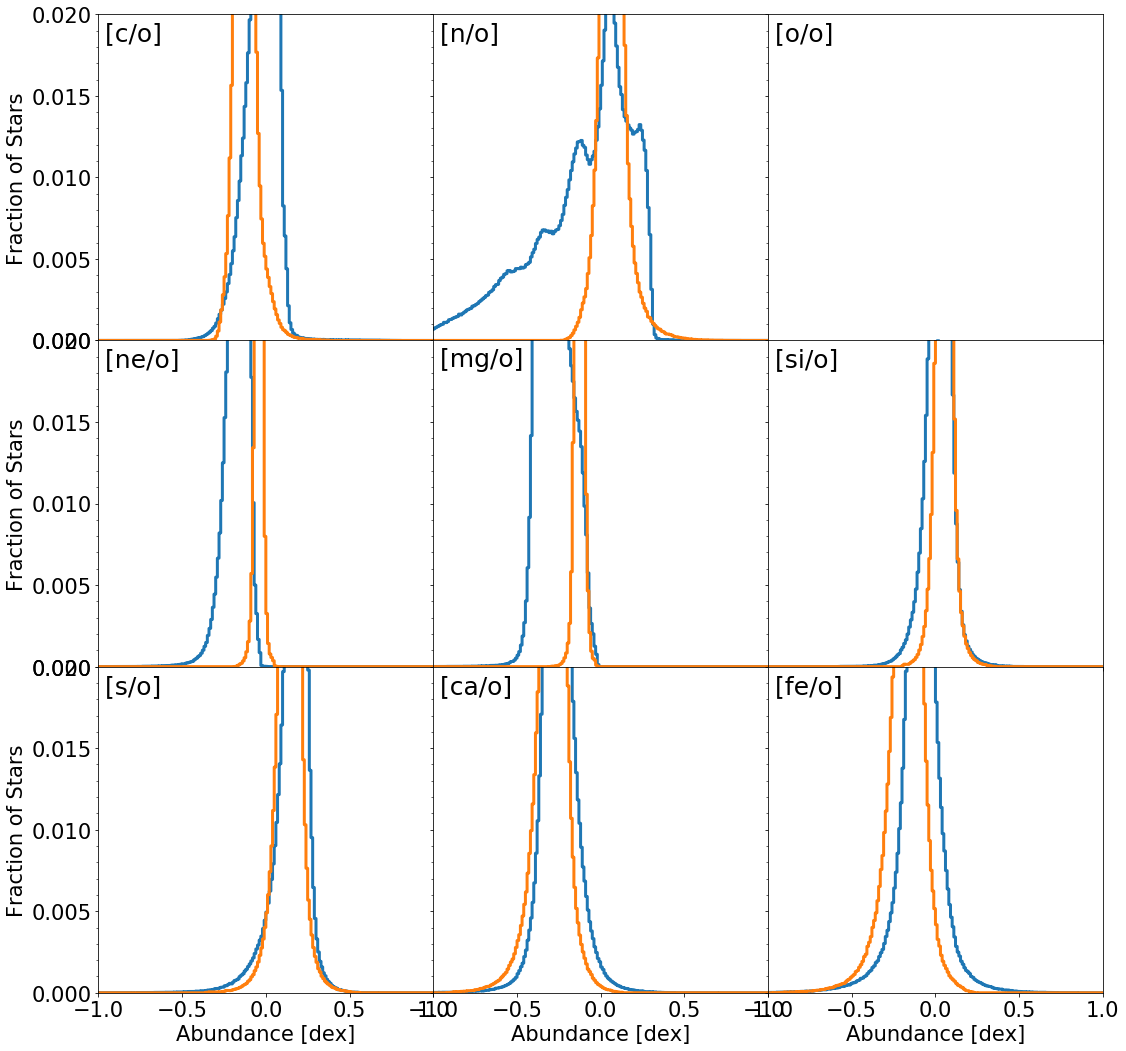

In [19]:
def plot_MDF_panel(denom='h', ptype='star', outname = None):
    
    fig,axes = plt.subplots(3,3,sharey=True,sharex=True)
    fig.set_size_inches(18,18)
    fig.subplots_adjust(wspace=0,hspace=0)

    xy=(0.8, 0.90)

    def plot_ax_2(ax, e1, e2, db = 0.001,
                            amin=0, amax=3,
                            color = None, label = None, yshift=0):
        if color is None:
            color = 'C0'
        if label is None:
            label = "post:"

        field = e1 + '_over_' + e2 + '_difference'
        bins, hist_age, hist_sim = all_stats[ptype]['errors'][field]['hist_age']['bin'], all_stats[ptype]['errors'][field]['hist_age'],all_stats[ptype]['errors'][field]['hist_sim']
        #hist1 = 1.0 - hist1 # reverse cum sum
        
        ax.step(bins,hist_sim['number'] / (1.0*np.sum(hist_age['number'])),where='post',
                         color='C0', label = 'Sim',lw=3)
        ax.step(bins,hist_age['number'] / (1.0*np.sum(hist_age['number'])),where='post',
                         color='C1', label = 'Age',lw=3)        

        return #stats

    axi,axj = 0,0
    i = 0
    for e in metals:
        axindex = (axi,axj)
            
        if e != denom:
            temp = plot_ax_2(axes[axindex], e, denom,
                      color = 'C%i'%(i), yshift=i)
        else:
            axes[axindex].step([0.01,0.02],[0.000001,0.0000001])
            
            
        axes[axindex].set_ylim(0,0.02)
        axes[axindex].set_xlim(-1,1)
        #axes[axindex].semilogy()
            
        axj = axj + 1
        if axj >= 3:
            axj = 0
            axi = axi + 1
            
            #all_stats['O'][k] = plot_ax_2(axes[0], 'O','H', k, all_data[k],
            #    color = 'C%i'%(i), label = k, yshift=i)
        #all_stats['Fe'][k] = plot_ax_2(axes[1],'Fe','H',k, all_data[k],
        #        color = 'C%i'%(i), label = k, yshift=i)
        #all_stats['N'][k] = plot_ax_2(axes[2], 'N','H', k, all_data[k],
        #        color = 'C%i'%(i), label = k, yshift=i)

    for i in np.arange(3):
        axes[(i,0)].set_ylabel("Fraction of Stars")    
        axes[(2,i)].set_xlabel("Abundance [dex]")
        #axes[(2,i)].set_xticks([0.001,0.01,0.1,1.0])
        #axes[(2,i)].set_xticklabels(["0.001","0.01","0.1","1.0"])
        axes[(i,0)].yaxis.set_minor_locator(AutoMinorLocator())

    xy = (0.02,0.92)
    axi,axj = 0,0
    for e in metals:
        axes[(axi,axj)].annotate('[' + e + '/' + denom + '] ', xy=xy,xycoords='axes fraction', size = 25)
        axj = axj + 1
        if axj >= 3:
            axj = 0
            axi = axi + 1
                    
        #axes[1].annotate('[Fe/H]', xy=xy,xycoords='axes fraction', size = 30)
        #axes[2].annotate('[N/H]',xy=xy,xycoords='axes fraction',size=30)
    #axes[(0,0)]

    if outname is None:
        outname = snapshot_num + "_panel_" + denom + "_logbin_comparison_diff_" + ptype + ".png"
        
    fig.savefig(outname)
    #plt.show()
    
    return

ptype = 'star'
plot_MDF_panel(denom='h',outname=simulation+'/MDF_panel_' + denom + '_' +ptype+".png",ptype=ptype)
plot_MDF_panel(denom='fe',outname=simulation+'/MDF_panel_' + denom + '_' +ptype+".png",ptype=ptype)
plot_MDF_panel(denom='o',outname=simulation+'/MDF_panel_' + denom + '_' +ptype+".png",ptype=ptype)

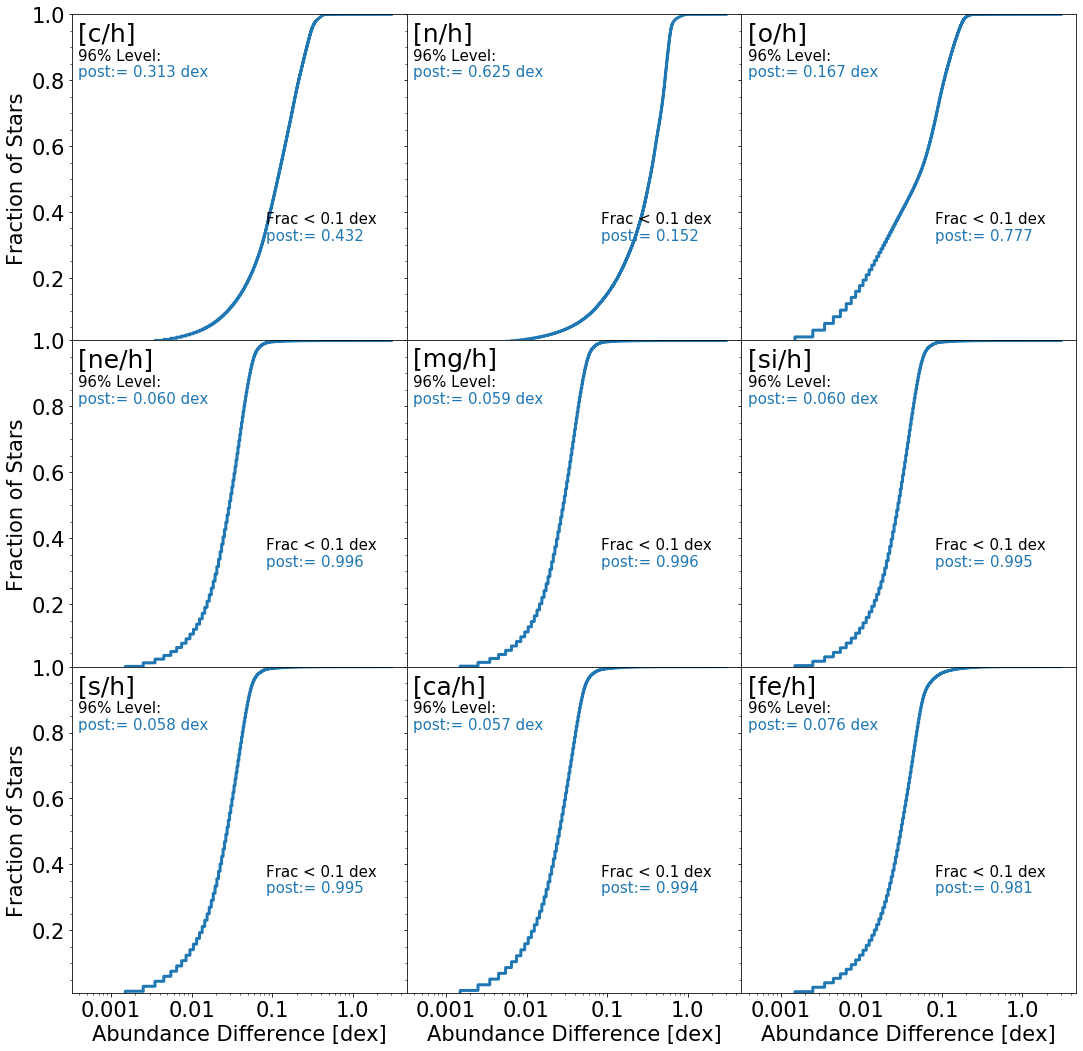

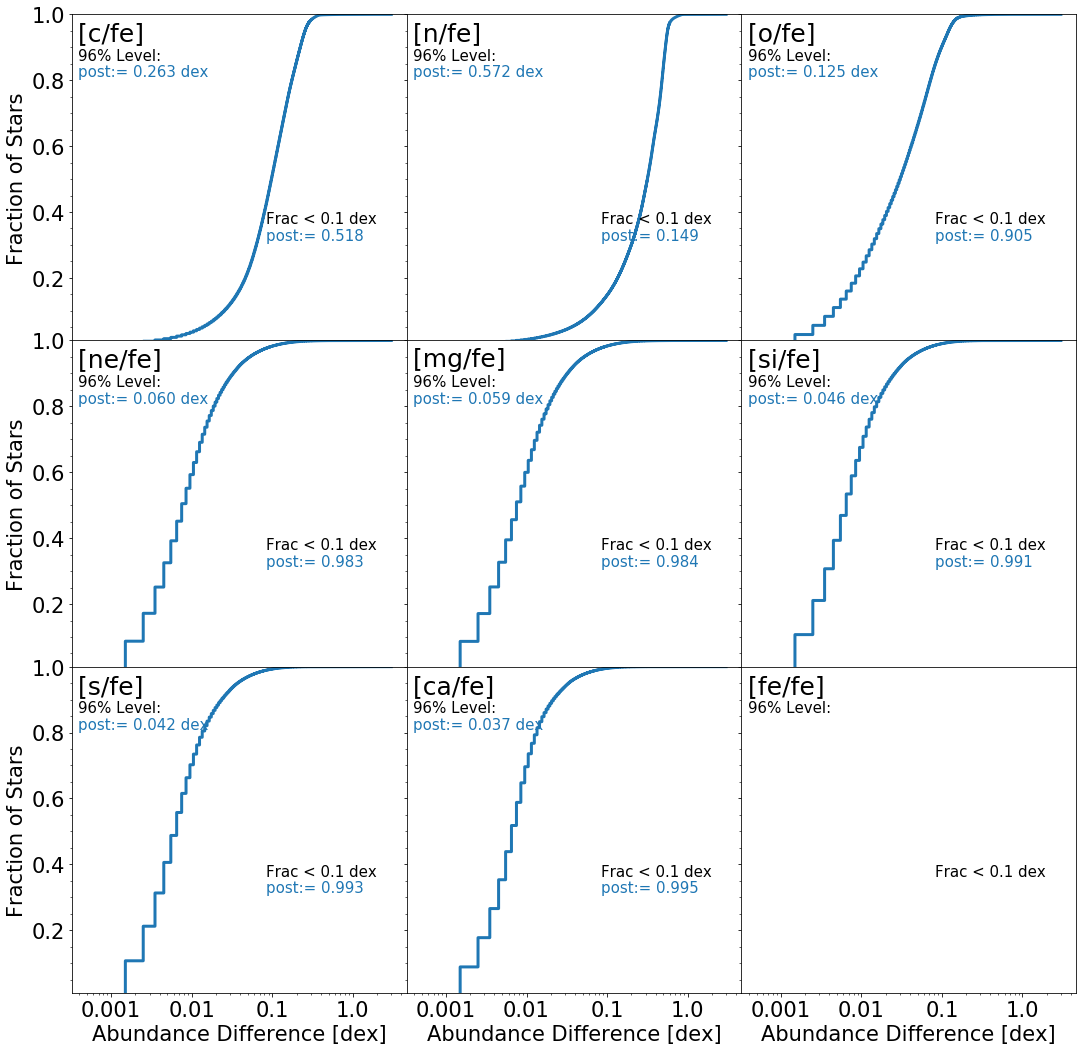

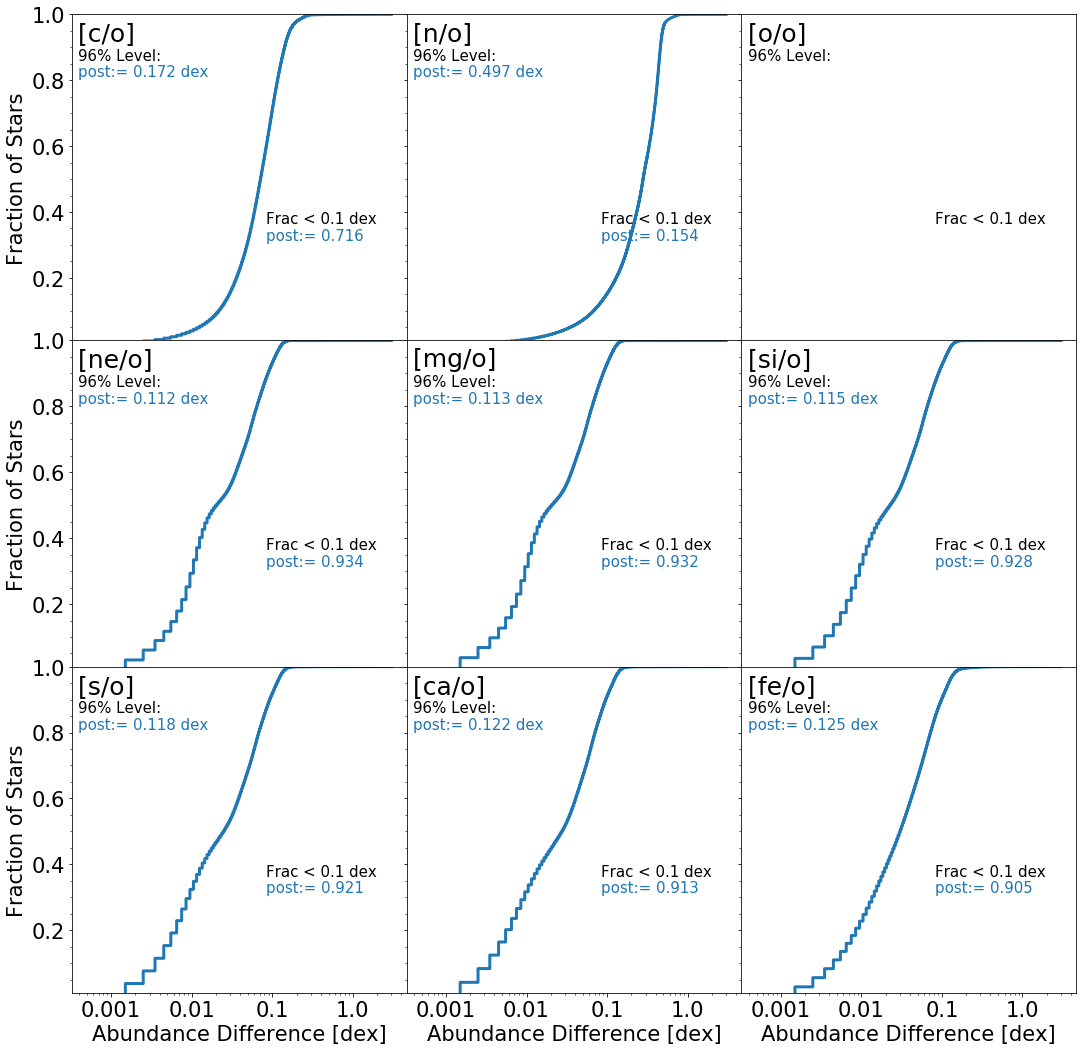

In [9]:
def plot_error_panel(denom='h', ptype='star', outname = None):
    
    fig,axes = plt.subplots(3,3,sharey=True,sharex=True)
    fig.set_size_inches(18,18)
    fig.subplots_adjust(wspace=0,hspace=0)

    xy=(0.8, 0.90)

    def plot_ax_2(ax, e1, e2, db = 0.001,
                            amin=0, amax=3,
                            color = None, label = None, yshift=0):
        if color is None:
            color = 'C0'
        if label is None:
            label = "post:"

        field = e1 + '_over_' + e2 + '_difference'
        
        bins, hist1, stats = all_stats[ptype]['errors'][field]['hist']['bin'], all_stats[ptype]['errors'][field]['hist']['sum.cum'], all_stats[ptype]['errors'][field]
        hist1 = 1.0 - hist1 # reverse cum sum
        
        ax.step(bins,hist1,where='post',
                         color=color, label = label,lw=3)

        yoff = 0.6 + 0.05*(yshift)

        ax.text(xy[0]-0.22,xy[1]-yoff, label + '= %0.3f '%all_stats[ptype]['errors'][field]['0.1dex'],
                verticalalignment='bottom',horizontalalignment='left',
                transform = ax.transAxes, color = color, fontsize = 15)

        ax.text(0.02, 0.80-0.05*yshift, label + '= %0.3f dex'%all_stats[ptype]['errors'][field]['96'],
                verticalalignment='bottom',horizontalalignment='left',
                transform=ax.transAxes, color=color, fontsize=15)

                #xy=(xy[0]-0.32,xy[1]-0.2-yoff),xycoords='axes fraction',
#                    size = 15)

        return stats



    for a2 in axes:
        for a in a2:
            a.text(xy[0]-0.22,xy[1] - (0.6-0.05), "Frac < 0.1 dex",
                verticalalignment = 'bottom', horizontalalignment='left',
                transform = a.transAxes, color = 'black', fontsize = 15)
            
            
            a.text(0.02, .85, "96% Level:",
                    verticalalignment = "bottom", horizontalalignment='left',
                    transform = a.transAxes, color = 'black', fontsize = 15)

    axi,axj = 0,0
    i = 0
    for e in metals:
        axindex = (axi,axj)
            
        if e != denom:
            temp = plot_ax_2(axes[axindex], e, denom,
                      color = 'C%i'%(i), yshift=i)
        else:
            axes[axindex].step([0.01,0.02],[0.000001,0.0000001])
            
            
        axes[axindex].set_ylim(0.01,1.0)
        axes[axindex].semilogx()
            
        axj = axj + 1
        if axj >= 3:
            axj = 0
            axi = axi + 1
            
            #all_stats['O'][k] = plot_ax_2(axes[0], 'O','H', k, all_data[k],
            #    color = 'C%i'%(i), label = k, yshift=i)
        #all_stats['Fe'][k] = plot_ax_2(axes[1],'Fe','H',k, all_data[k],
        #        color = 'C%i'%(i), label = k, yshift=i)
        #all_stats['N'][k] = plot_ax_2(axes[2], 'N','H', k, all_data[k],
        #        color = 'C%i'%(i), label = k, yshift=i)

    for i in np.arange(3):
        axes[(i,0)].set_ylabel("Fraction of Stars")    
        axes[(2,i)].set_xlabel("Abundance Difference [dex]")
        axes[(2,i)].set_xticks([0.001,0.01,0.1,1.0])
        axes[(2,i)].set_xticklabels(["0.001","0.01","0.1","1.0"])
        axes[(i,0)].yaxis.set_minor_locator(AutoMinorLocator())

    xy = (0.02,0.92)
    axi,axj = 0,0
    for e in metals:
        axes[(axi,axj)].annotate('[' + e + '/' + denom + '] ', xy=xy,xycoords='axes fraction', size = 25)
        axj = axj + 1
        if axj >= 3:
            axj = 0
            axi = axi + 1
                    
        #axes[1].annotate('[Fe/H]', xy=xy,xycoords='axes fraction', size = 30)
        #axes[2].annotate('[N/H]',xy=xy,xycoords='axes fraction',size=30)
    #axes[(0,0)]

    if outname is None:
        outname = snapshot_num + "_panel_" + denom + "_logbin_comparison_diff_" + ptype + ".png"
        
    fig.savefig(outname)
    #plt.show()
    
    return

ptype = 'star'
for denom in ['h','fe','o']:
    plot_error_panel(denom=denom,outname=simulation+'/error_panel_' + denom + '_' +ptype+".png",ptype=ptype)
#plot_error_panel(denom='fe',outname=simulation+'/error_panel_' + denom + '_' +ptype+".png",ptype=ptype)
#plot_error_panel(denom='o',outname=simulation+'/error_panel_' + denom + '_' +ptype+".png",ptype=ptype)

In [27]:
all_stats['gas']['temperature']['c_over_fe_difference'].keys()

dict_keys(['bin.mid', 'y.values', 'indices', 'number', 'bin.min', 'bin.max', 'limits', 'median', 'percent.16', 'percent.84', 'percent.2', 'percent.98', 'percent.0.1', 'percent.99.9', 'percent.25', 'percent.75', 'percents.68', 'percents.95', 'median.dif.2', 'median.dif.16', 'median.dif.84', 'median.dif.98', 'median.difs.68', 'median.difs.95', 'average', 'std', 'sem', 'std.lo', 'std.hi', 'min', 'max', 'percent.50', 'average.50', 'sem.lo', 'sem.hi'])

/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: UserWarning: AutoMinorLocator does not work with logarithmic scale
/home/aemerick/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: AutoMinorLocator does not work with logarithmic scale
  func(*args, **kwargs)
/home/aemerick/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


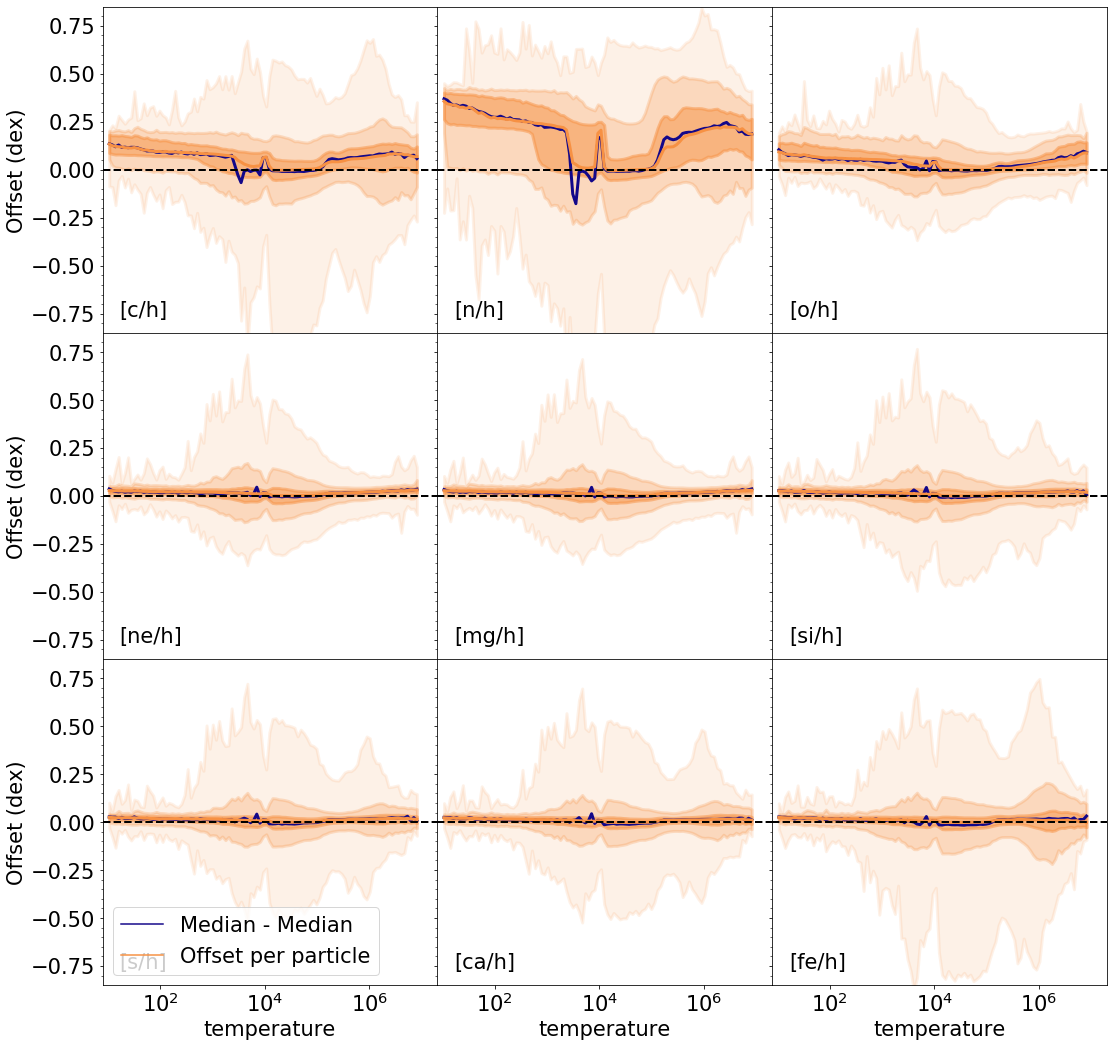

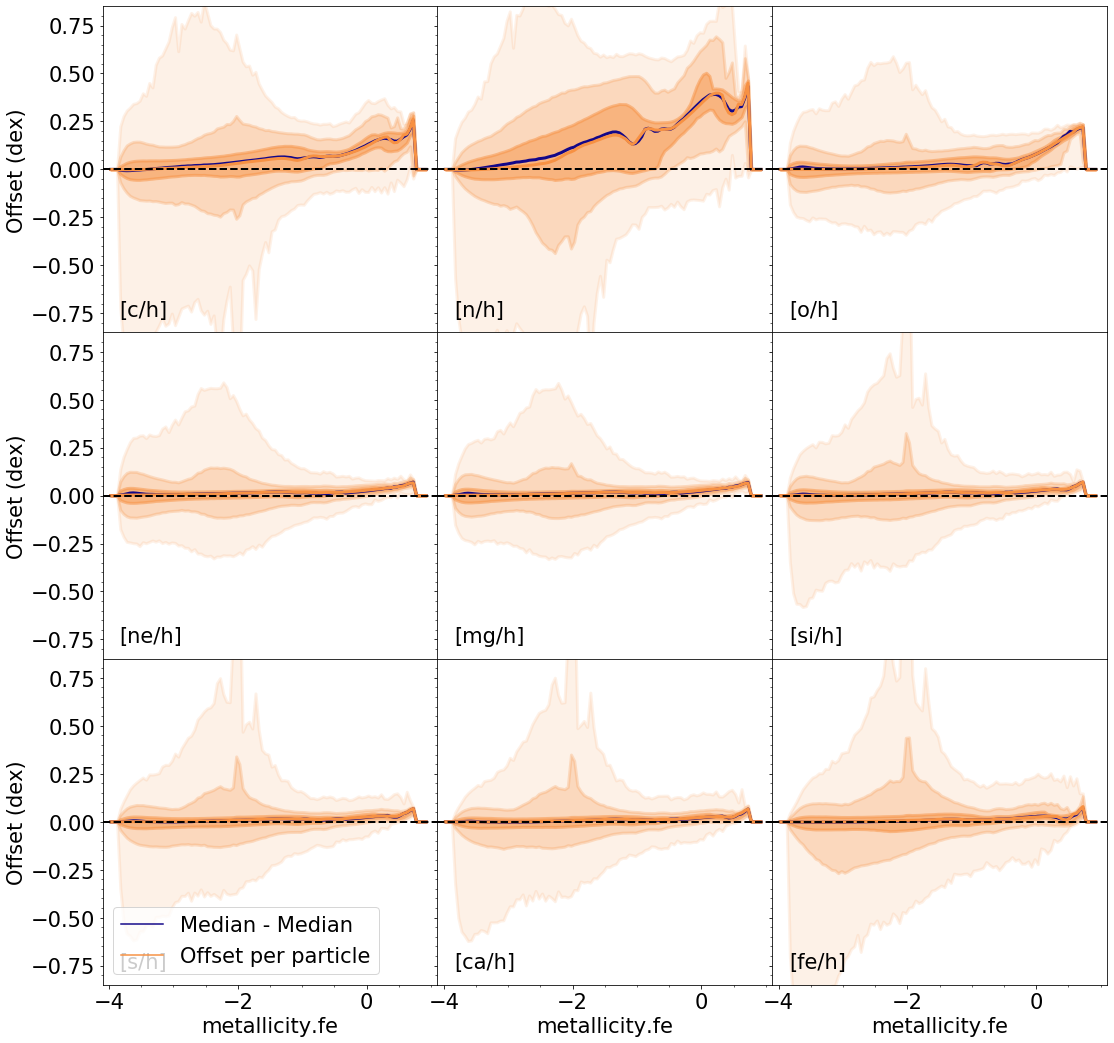

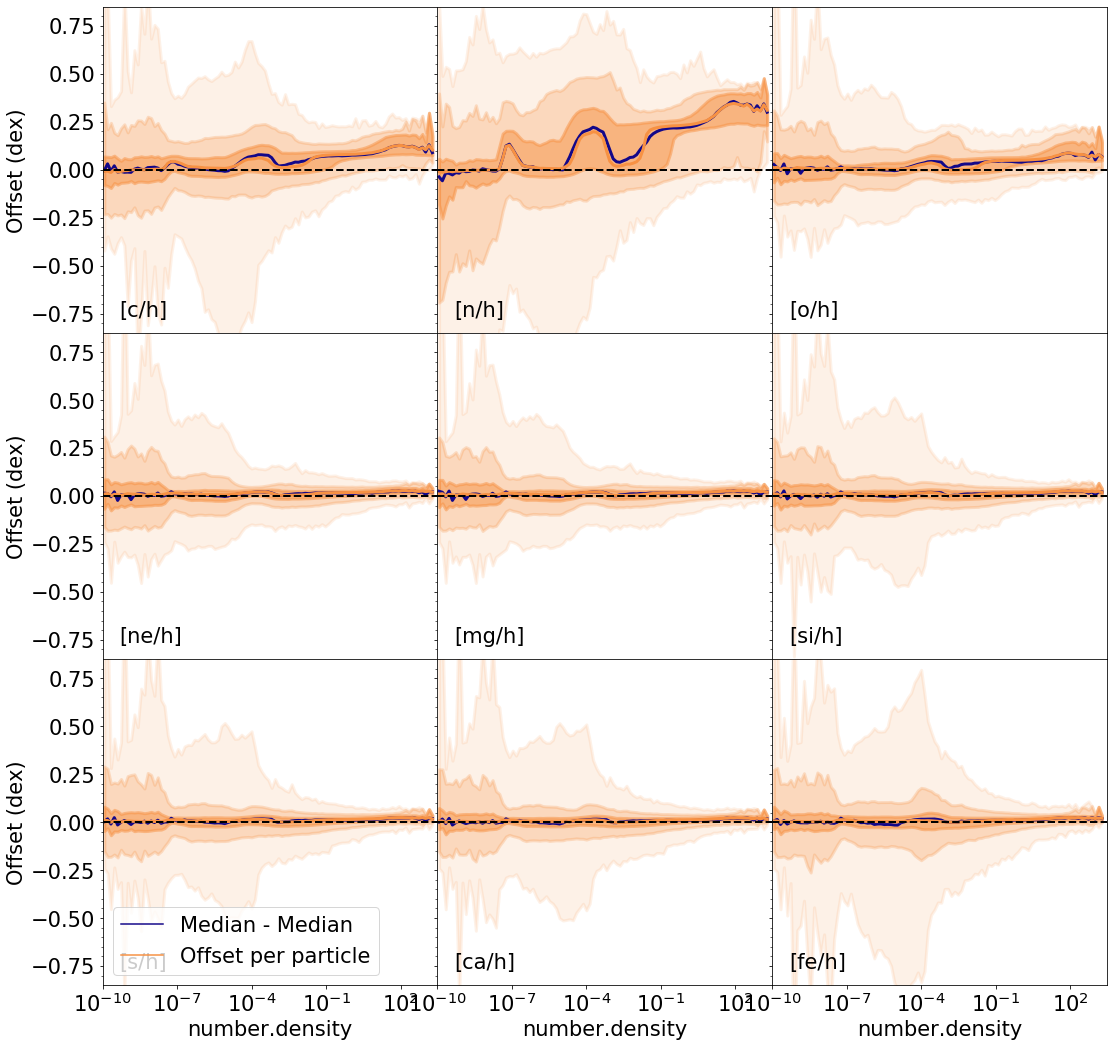

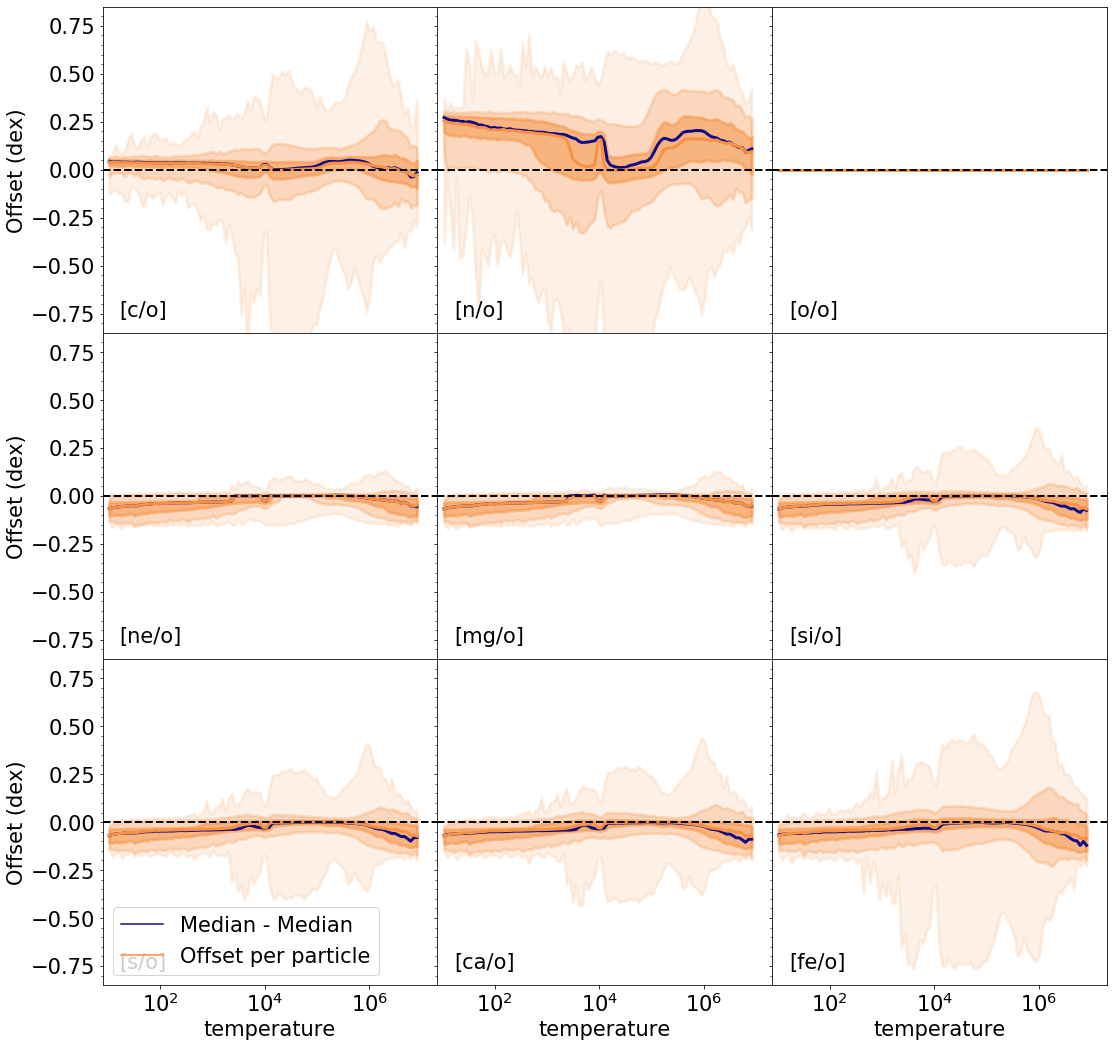

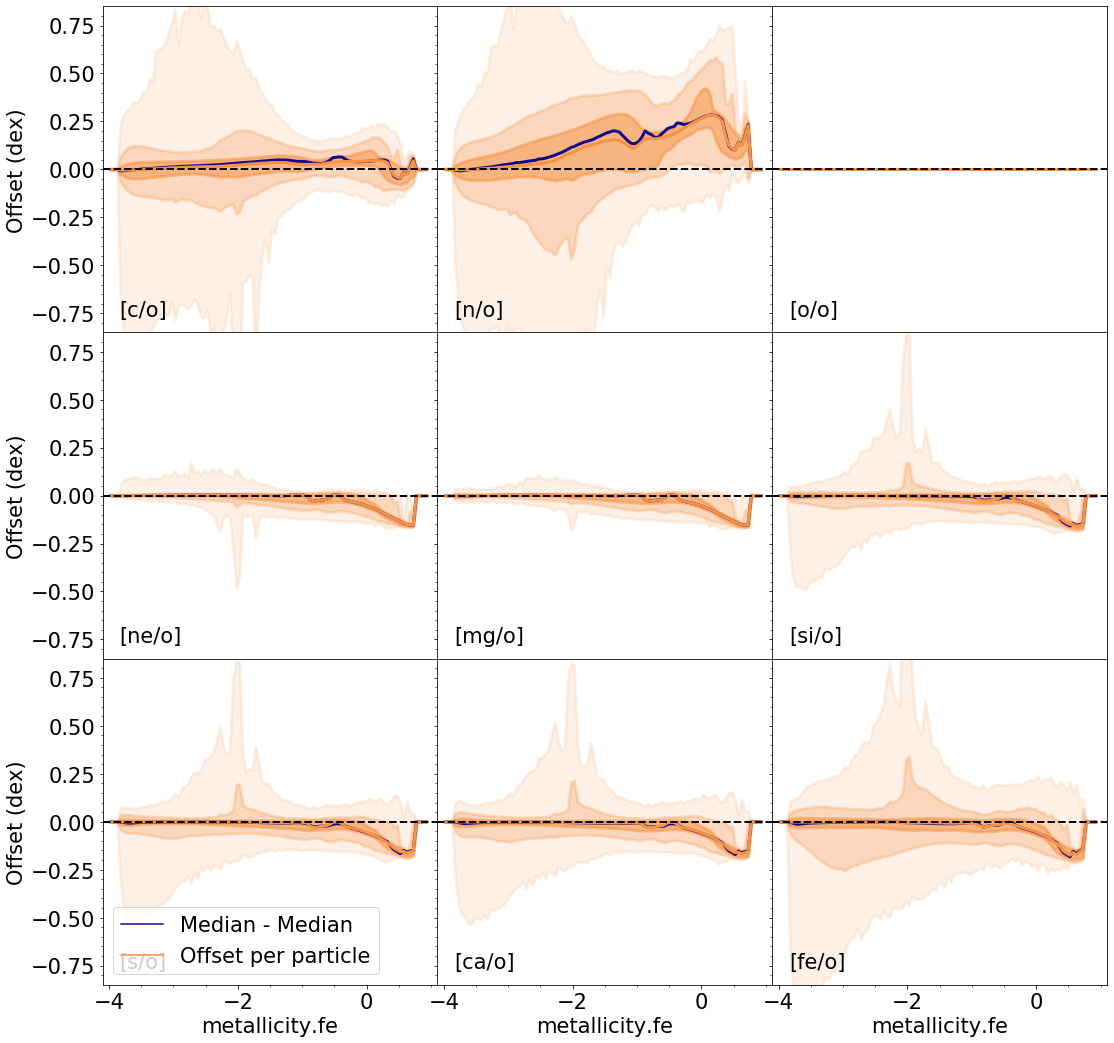

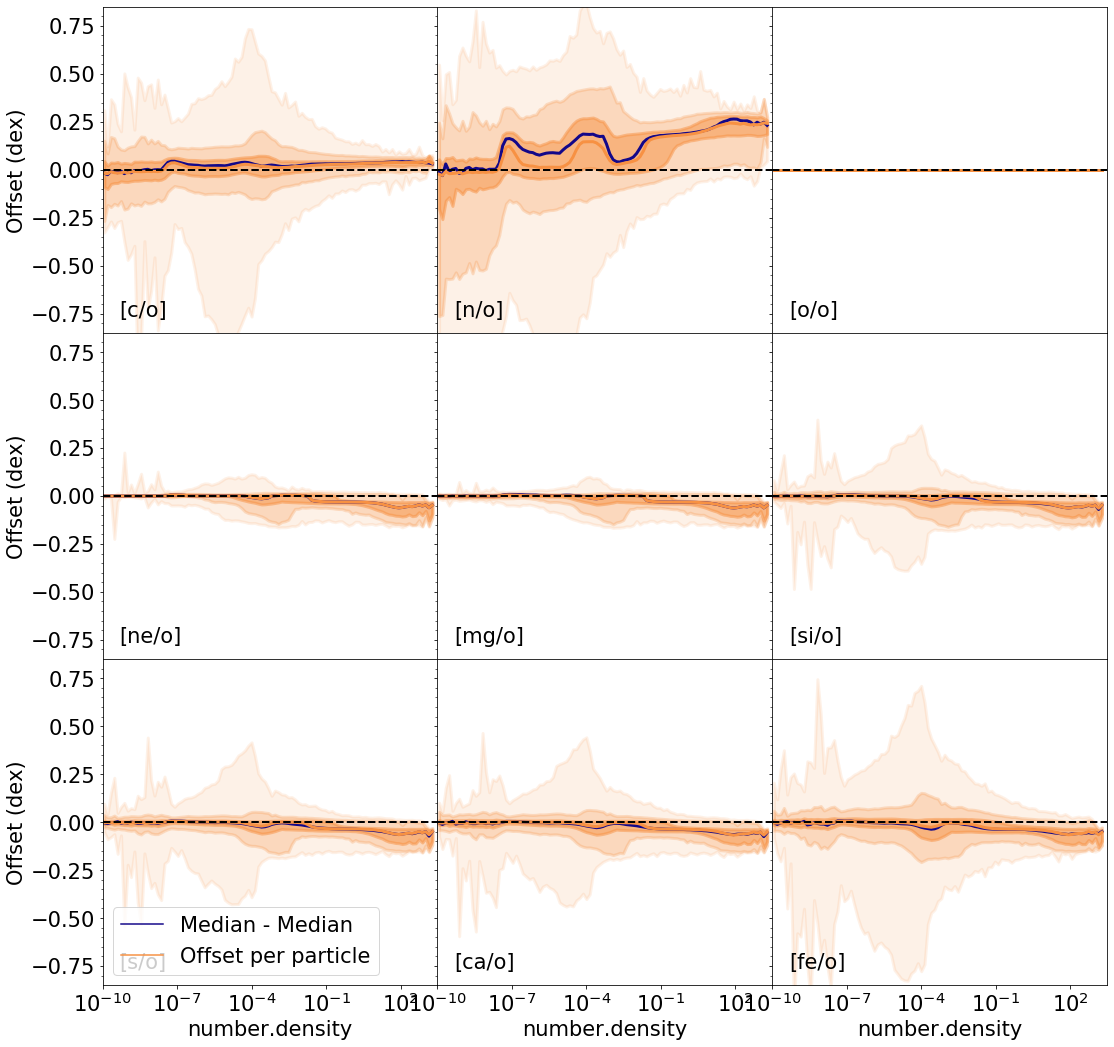

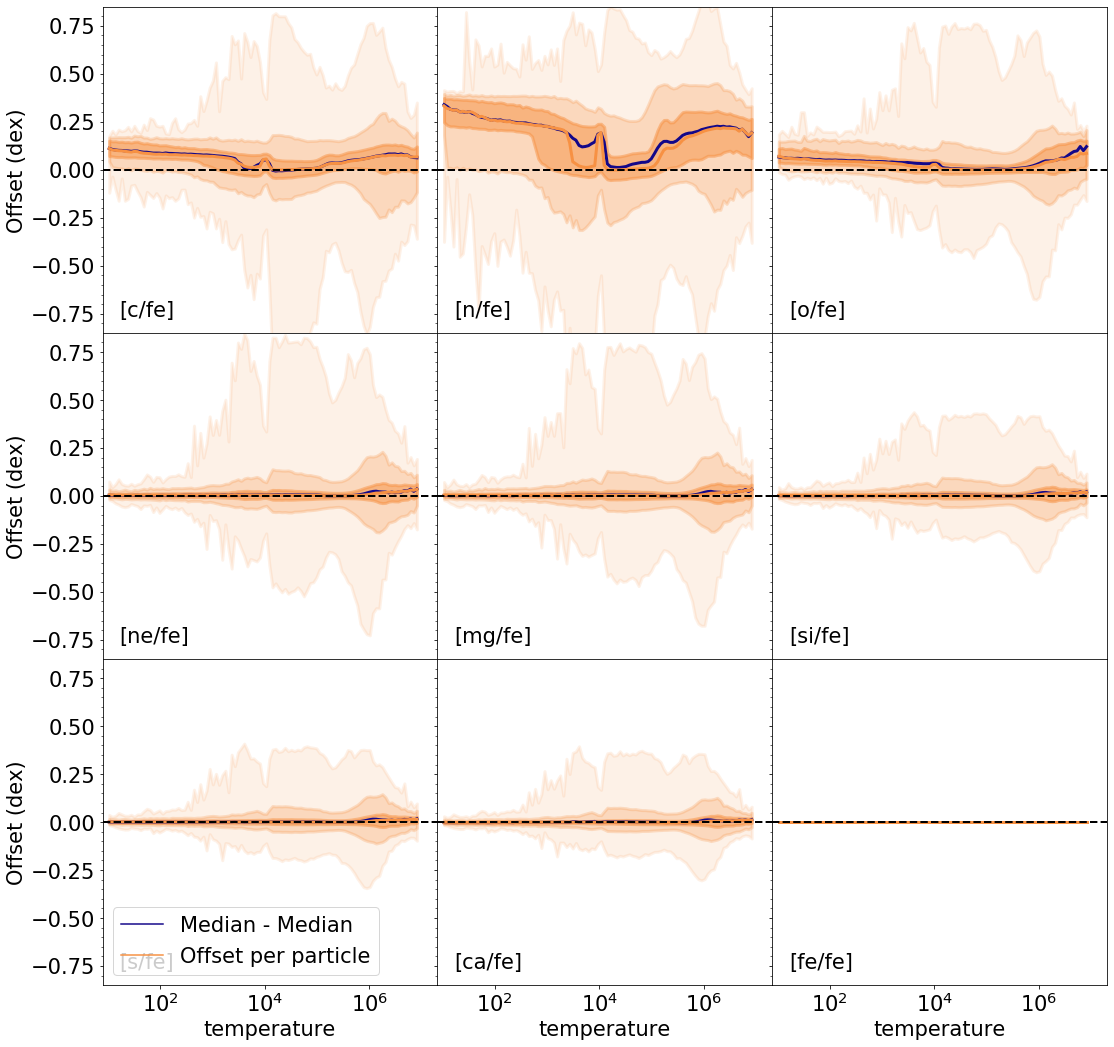

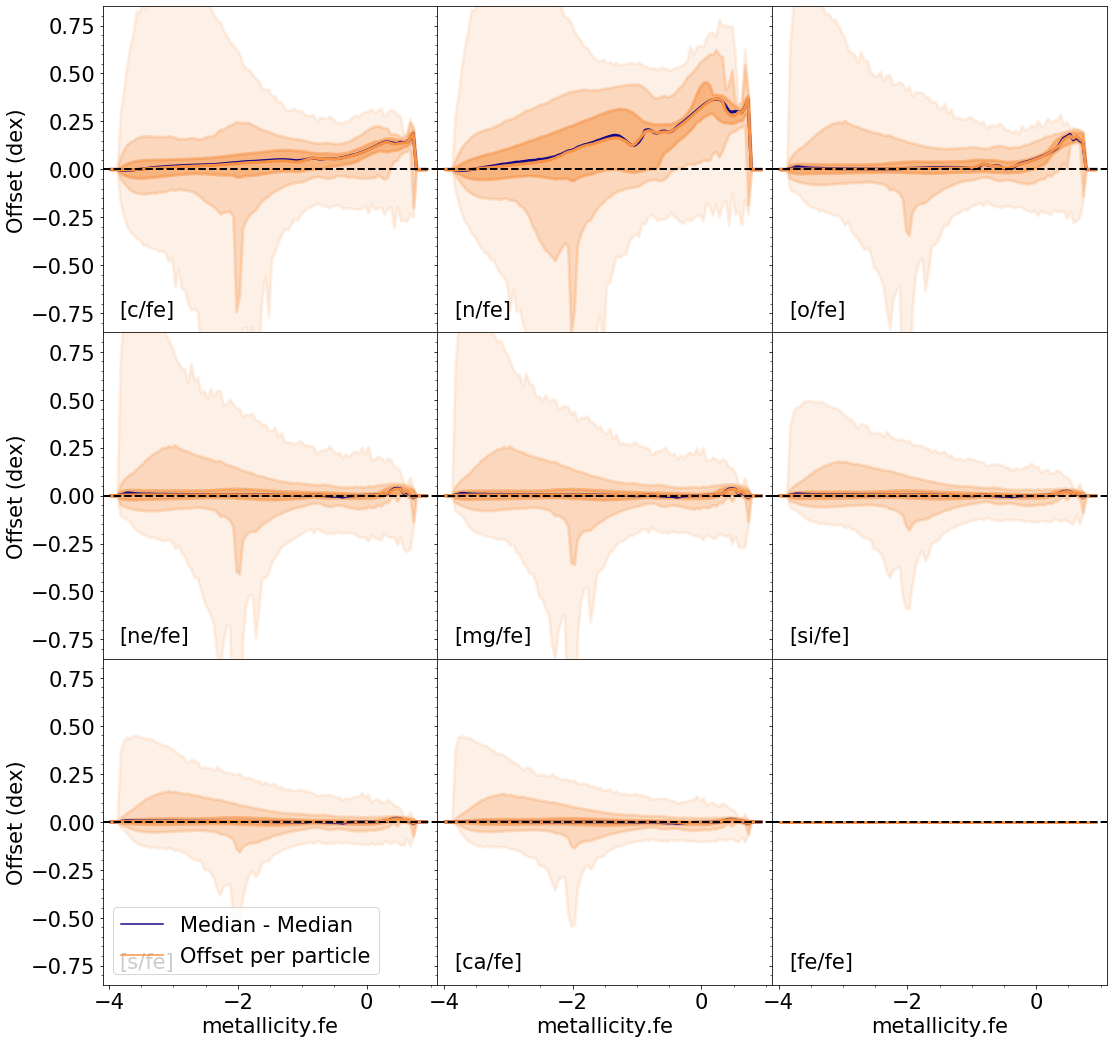

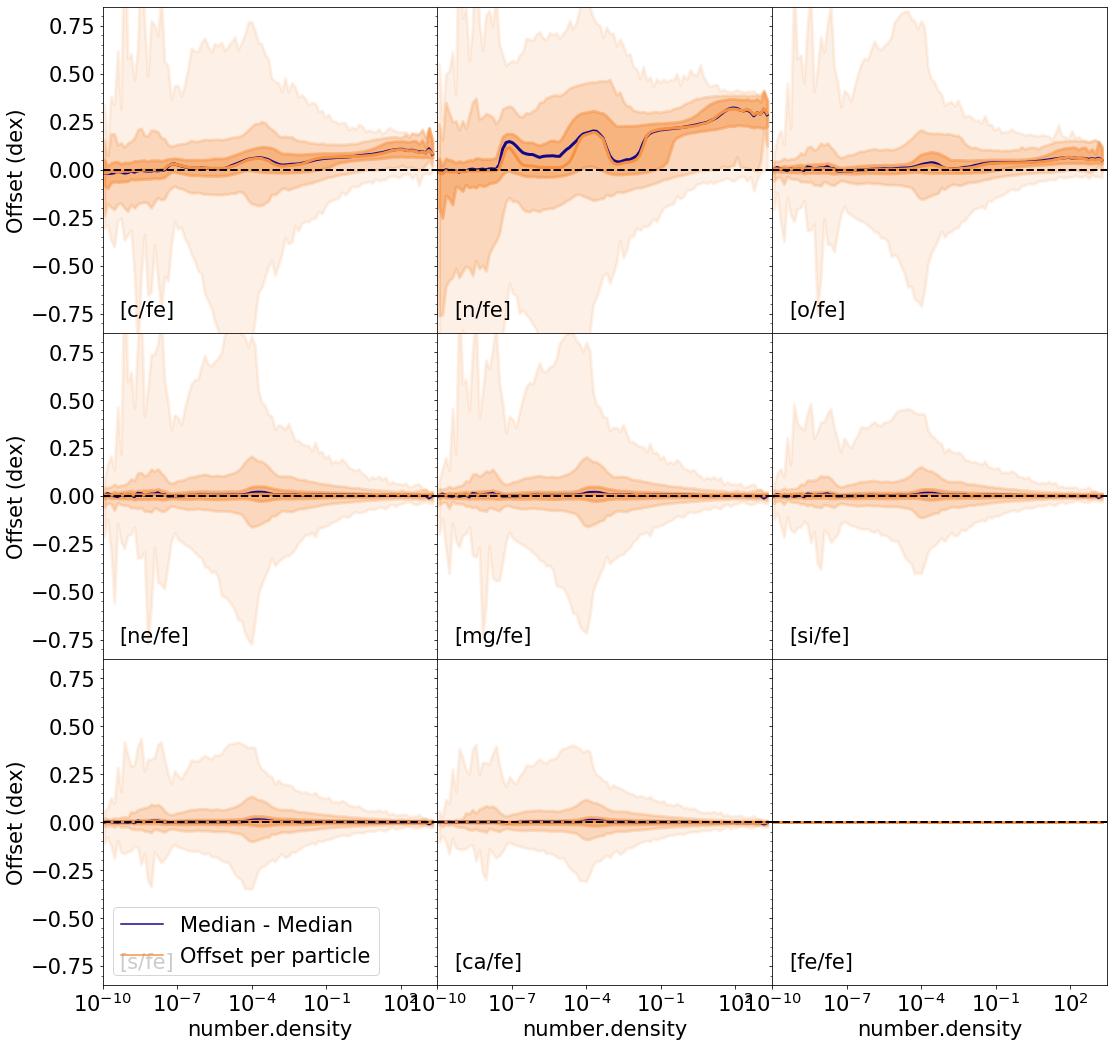

In [10]:
plot_settings()
#
#
# plot as a function of some other field
#   
# 
#


def plot_vs_field(_stats, xfield, xlim=None, denom='h',
                  scaling='log',nbins=100, select_dict=None, ptype='gas',
                  xfield_label = None, outname = None, xconversion=1.0):
    """
    
    params: select_dict : dict : Optional. dictionionary in form {'fieldname':(minval,maxval)} to
                                 select data to plot
    """
    color1 = plasma(0.01)
    color2 = plasma(0.74)
    
    
    def _denom_field_str(_denom,_k):
        if denom == 'h':
            _d = ''
        else:
            _d = ' - ' + _k   + _denom   
        return _d    
    
    if xfield_label is None:
        xfield_label = xfield
        
    if outname is None:
        outname = xfield + '_median_offsets_' + ptype + '_' + '_denom.png'                        
                                 

    fig,all_axes=plt.subplots(3,3,sharex=True,sharey=True)
    fig.set_size_inches(6*3,6*3)
                                 
    fig.subplots_adjust(hspace=0,wspace=0)
                                 
    # now plot:
    axi = 0
    axj = 0
    for e in metals:
        axindex = (axi,axj)
        ax = all_axes[axindex]
        
        yfieldsim = 'metallicity.' + e + _denom_field_str(denom,'metallicity.')
        yfieldage = 'metallicity.agetracers.' + e + _denom_field_str(denom,'metallicity.agetracers.')
                                 
        x    = _stats[xfield][yfieldsim]['bin.mid'][:-1] * xconversion
        ysim = _stats[xfield][yfieldsim]['median'][:-1]
        yage = _stats[xfield][yfieldage]['median'][:-1]
                                        
        ax.plot(x, ysim - yage, lw = 3, color = color1)#, label = "Difference of Median")
                                 
                                 
        ydiff_stats = _stats[xfield][e + '_over_' + denom + '_difference']        
        ax.plot(x, ydiff_stats['median'][:-1], lw = 3, color = color2)#, label = 'Median Difference')
        ax.fill_between(x, ydiff_stats['percent.0.1'][:-1], ydiff_stats['percent.99.9'][:-1], 
                        lw = 3, color = color2, alpha=0.125)
        ax.fill_between(x, ydiff_stats['percent.2'][:-1], ydiff_stats['percent.98'][:-1], 
                        lw = 3, color = color2, alpha=0.25) 
        ax.fill_between(x, ydiff_stats['percent.16'][:-1], ydiff_stats['percent.84'][:-1], 
                        lw = 3, color = color2, alpha=0.5)            
                                 

        xy = (0.05,0.05)
        ax.annotate('[' + e + '/' + denom + ']', xy,xy,xycoords='axes fraction')
                                 
        if axj == 0:
            ax.set_ylabel("Offset (dex)")
        #else:
        #    ax.yaxis.set_ticklabels([])            
            
        if axi == 2:
            ax.set_xlabel(xfield_label)
        #else:
        #    ax.xaxis.set_ticklabels([])
            #ax.xaxis.set_xticks
            
            
        if scaling == 'log':
            ax.semilogx()
            
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())            
        
        if not (xlim is None):
            ax.set_xlim(xlim)
        ax.set_ylim(-0.85,0.85)
        
        ax.plot(ax.get_xlim(), [0.0,0.0],lw=2,ls='--',color='black')
        
        
        if e == 's':
            ax.plot(  [ax.get_xlim()[0]*0.1,ax.get_xlim()[0]*0.2],
                      [1,1], color = color1, label = 'Median - Median')
            ax.plot(  [ax.get_xlim()[0]*0.1,ax.get_xlim()[0]*0.2],
                      [1,1], color = color2, label = 'Offset per particle')
            ax.legend(loc='lower left')
            
        axj = axj + 1
        if axj >= 3:
            axi = axi + 1
            axj = 0
        
    fig.savefig(outname)

    return

for denom in ['h','o','fe']:
    plot_vs_field(all_stats['gas'], 'temperature',[8.0,2.0E7],scaling='log',denom=denom, outname=simulation+'/'+'X_over_'+denom+'-temperature.png')
    plot_vs_field(all_stats['gas'], 'metallicity.fe',[-4.1,1.1],scaling='linear',denom=denom, outname=simulation+ '/'+'X_over_'+denom+'-fe-over-h.png')
    plot_vs_field(all_stats['gas'], 'number.density', xlim=(1.0E-10,3000.0),
                  #xconversion = 1.989e+33 / ((3.086E21)**3),
                  scaling='log',denom=denom, outname=simulation+'/'+'X_over_' + denom + '-density.png')

c full ks  Ks_2sampResult(statistic=0.045887896717430765, pvalue=0.0)
n full ks  Ks_2sampResult(statistic=0.1833157491519051, pvalue=0.0)
o full ks  Ks_2sampResult(statistic=0.04283444407476869, pvalue=0.0)
ne full ks  Ks_2sampResult(statistic=0.04785998797849528, pvalue=0.0)
mg full ks  Ks_2sampResult(statistic=0.06967306338605078, pvalue=0.0)
si full ks  Ks_2sampResult(statistic=0.025909858805919672, pvalue=0.0)
s full ks  Ks_2sampResult(statistic=0.05922133848189873, pvalue=0.0)
ca full ks  Ks_2sampResult(statistic=0.030395319984663383, pvalue=0.0)
fe full ks  Ks_2sampResult(statistic=0.03775436568862578, pvalue=0.0)


/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: AutoMinorLocator does not work with logarithmic scale


c full ks  Ks_2sampResult(statistic=0.045887896717430765, pvalue=0.0)
n full ks  Ks_2sampResult(statistic=0.1833157491519051, pvalue=0.0)
o full ks  Ks_2sampResult(statistic=0.04283444407476869, pvalue=0.0)
ne full ks  Ks_2sampResult(statistic=0.04785998797849528, pvalue=0.0)
mg full ks  Ks_2sampResult(statistic=0.06967306338605078, pvalue=0.0)
si full ks  Ks_2sampResult(statistic=0.025909858805919672, pvalue=0.0)
s full ks  Ks_2sampResult(statistic=0.05922133848189873, pvalue=0.0)
ca full ks  Ks_2sampResult(statistic=0.030395319984663383, pvalue=0.0)
fe full ks  Ks_2sampResult(statistic=0.03775436568862578, pvalue=0.0)
c full ks  Ks_2sampResult(statistic=0.045887896717430765, pvalue=0.0)
n full ks  Ks_2sampResult(statistic=0.1833157491519051, pvalue=0.0)
o full ks  Ks_2sampResult(statistic=0.04283444407476869, pvalue=0.0)
ne full ks  Ks_2sampResult(statistic=0.04785998797849528, pvalue=0.0)
mg full ks  Ks_2sampResult(statistic=0.06967306338605078, pvalue=0.0)
si full ks  Ks_2sampResul

KeyboardInterrupt: 

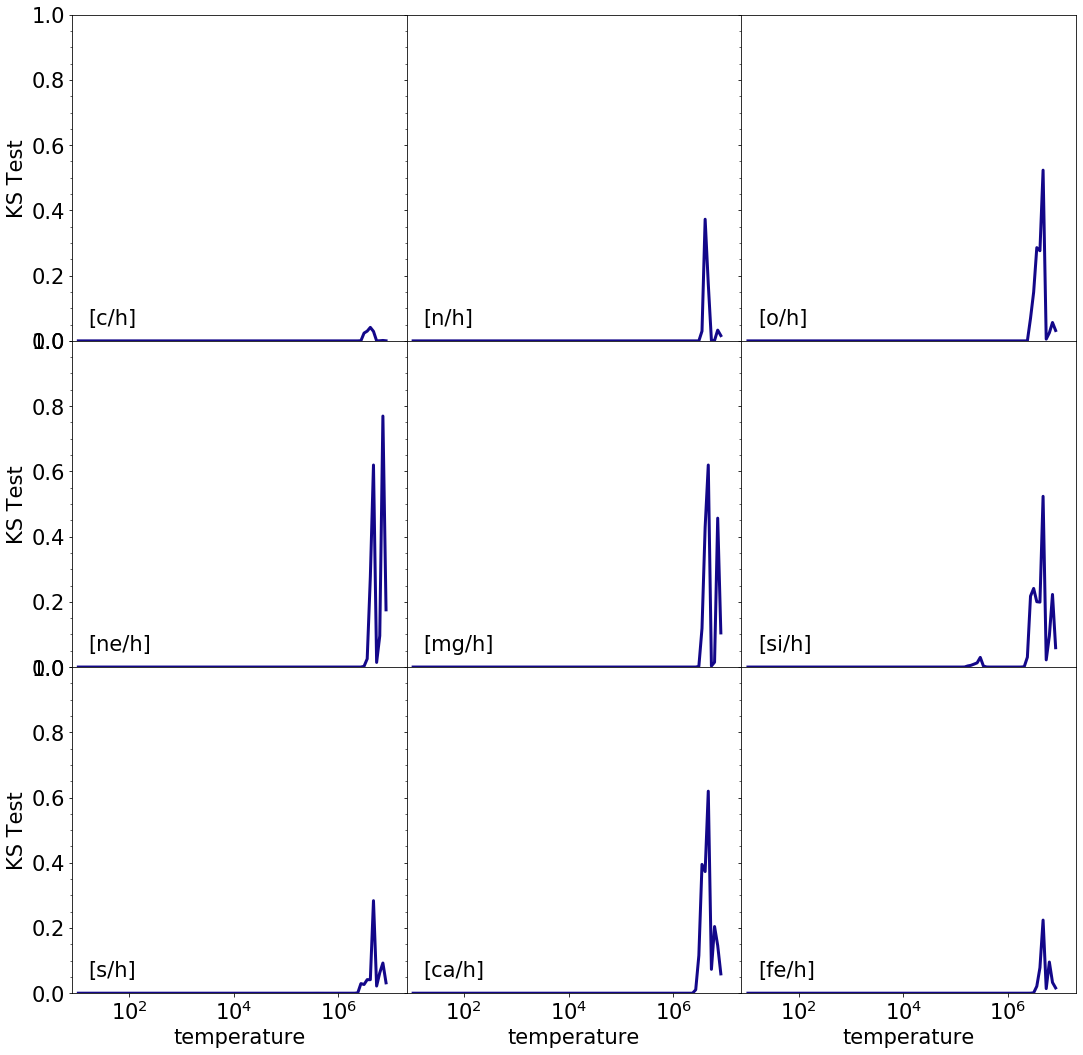

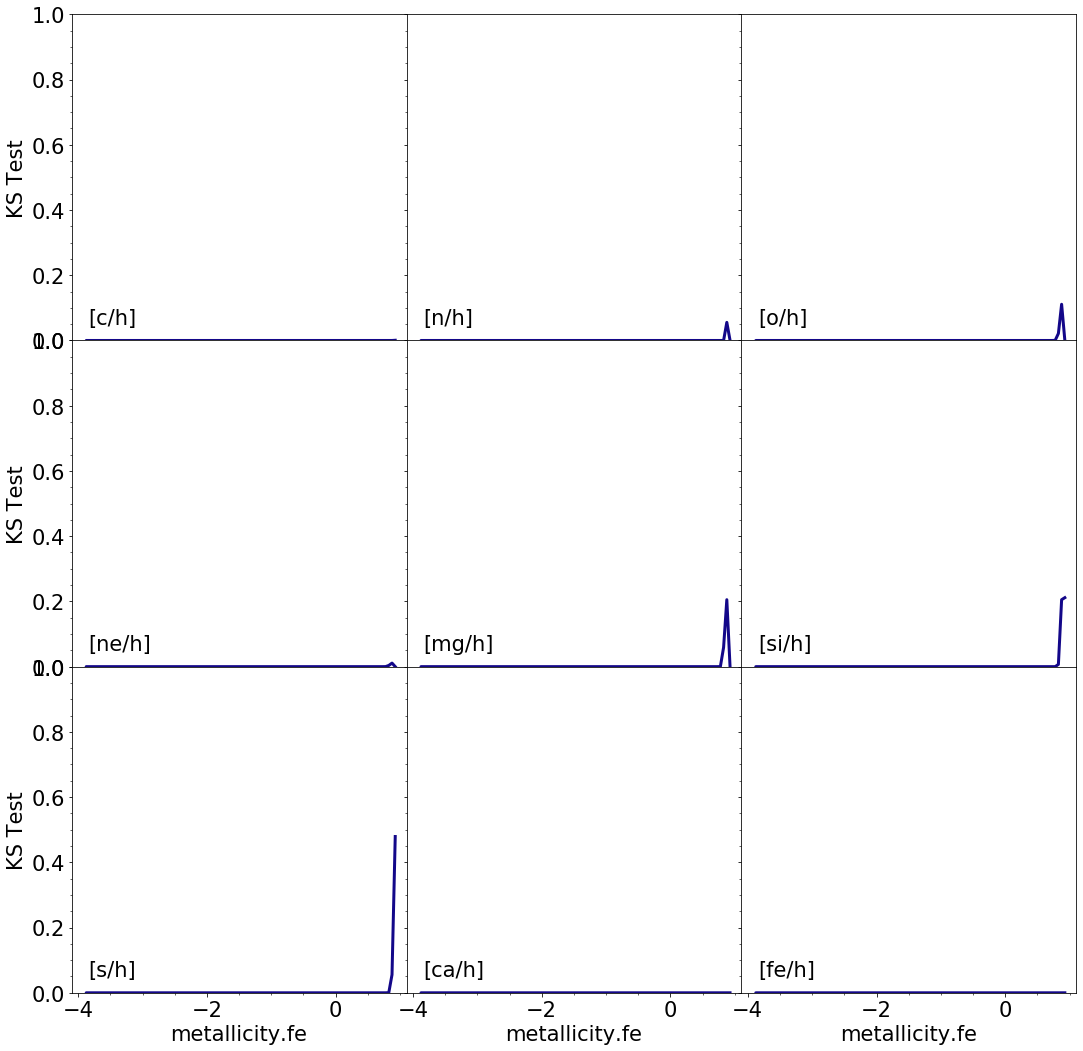

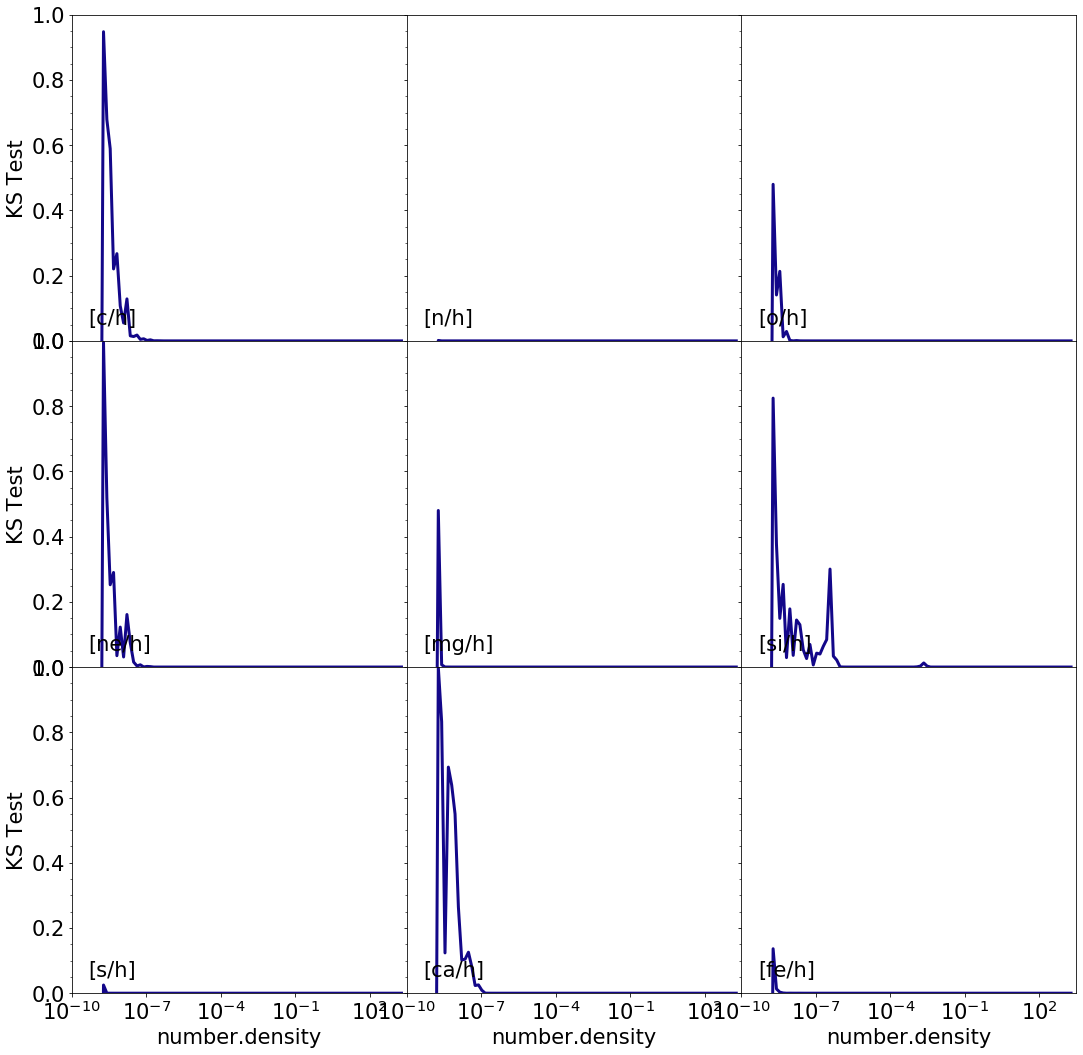

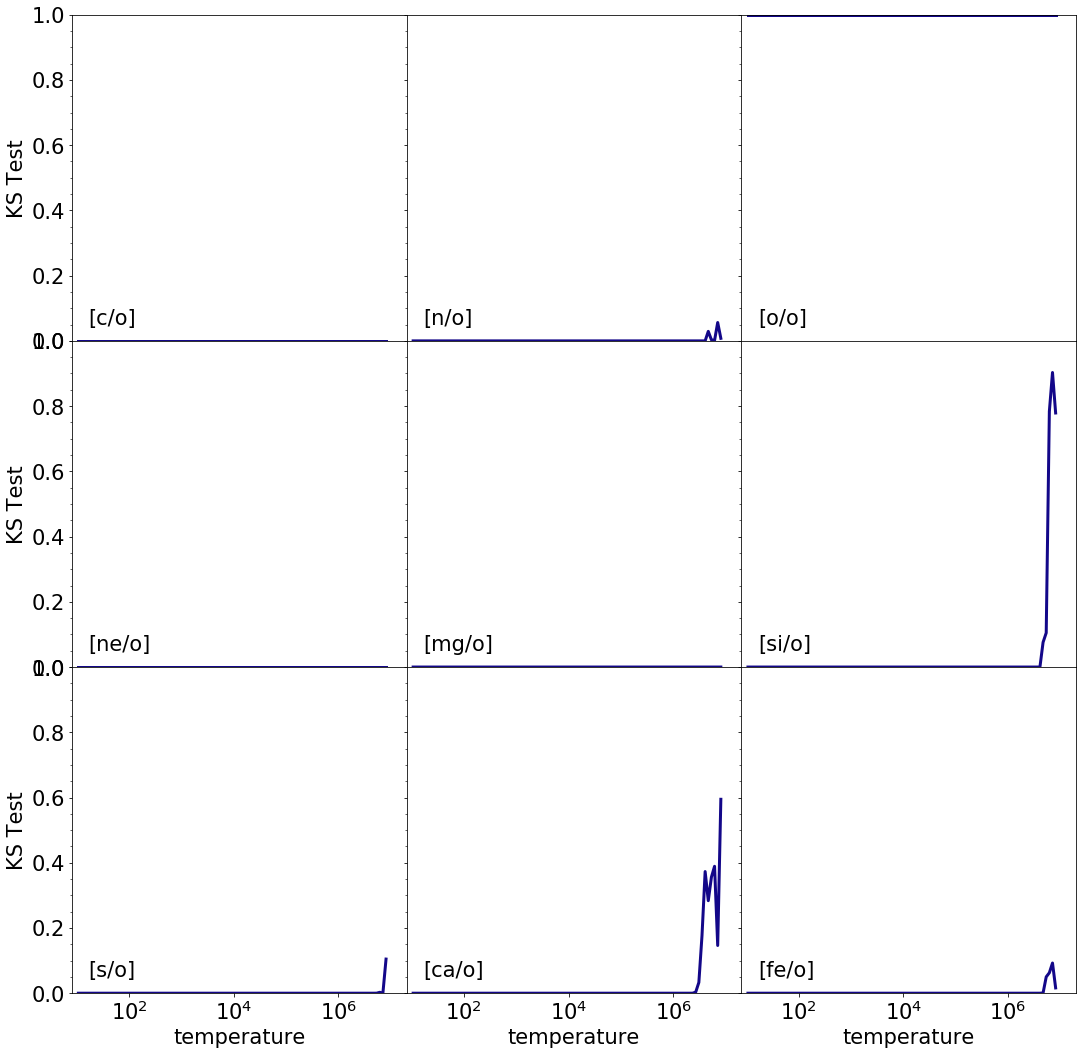

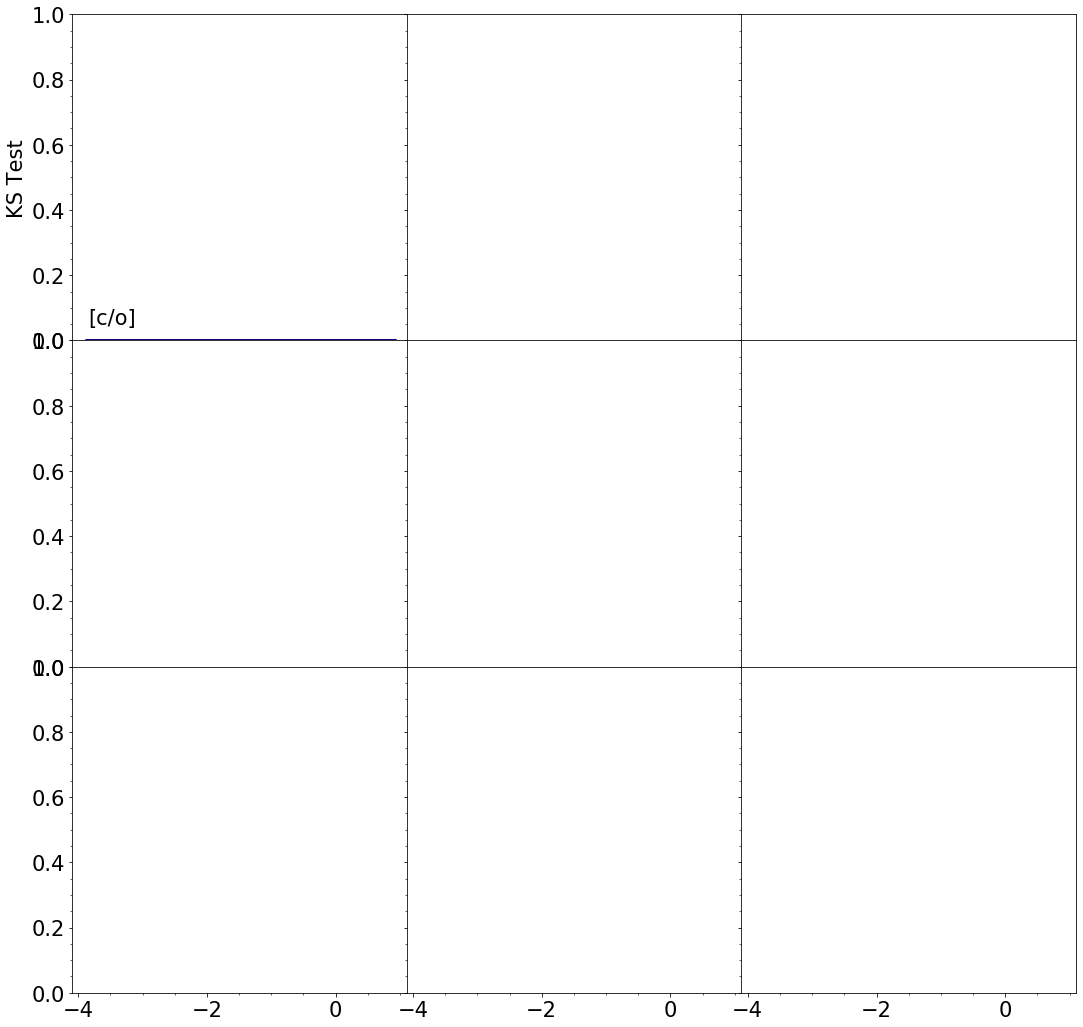

In [20]:
plot_settings()
#
#
# plot as a function of some other field
#   
# 
#
from scipy import stats as scipy_stats

def plot_ks_vs_field(_part, _stats, xfield, xlim=None, denom='h',
                  scaling='log',nbins=100, select_dict=None, ptype='gas',
                  xfield_label = None, outname = None, xconversion=1.0):
    """
    
    params: select_dict : dict : Optional. dictionionary in form {'fieldname':(minval,maxval)} to
                                 select data to plot
    """
    color1 = plasma(0.01)
    color2 = plasma(0.74)
    
    
    def _denom_field_str(_denom,_k):
        if denom == 'h':
            _d = ''
        else:
            _d = ' - ' + _k   + _denom   
        return _d    
    
    if xfield_label is None:
        xfield_label = xfield
        
    if outname is None:
        outname = xfield + '_median_offsets_' + ptype + '_' + '_denom.png'                        
                                 

    fig,all_axes=plt.subplots(3,3,sharex=True,sharey=True)
    fig.set_size_inches(6*3,6*3)
                                 
    fig.subplots_adjust(hspace=0,wspace=0)
                                 
    # now plot:
    axi = 0
    axj = 0
    for e in metals:
        axindex = (axi,axj)
        ax = all_axes[axindex]
        
        yfieldsim = 'metallicity.' + e + _denom_field_str(denom,'metallicity.')
        yfieldage = 'metallicity.agetracers.' + e + _denom_field_str(denom,'metallicity.agetracers.')
                                 
        x    = _stats[xfield][yfieldsim]['bin.mid'][:-1] * xconversion
        
        xmin = _stats[xfield][yfieldsim]['bin.min'][:-1] * xconversion
        xmax = _stats[xfield][yfieldsim]['bin.max'][:-1] * xconversion
        
        ysim = _part[ptype].prop(yfieldsim)
        yage = _part[ptype].prop(yfieldage)
        
        ks_vals = np.zeros(np.size(x))
        for i in np.arange(np.size(x)):
            select = (_part[ptype].prop(xfield) > xmin[i]) * (_part[ptype].prop(xfield)<xmax[i]) * (_part[ptype].prop('metallicity.o')>-3.7)
            
            if np.size(ysim[select]) > 0:
                ks_vals[i] = scipy_stats.ks_2samp(ysim[select],yage[select])[1]
            else:
                ks_vals[i] = -1
            
        ax.plot(x, ks_vals, lw = 3, color = color1)#, label = "Difference of Median")                     

        select = _part[ptype].prop('metallicity.o') > -3.7
        print(e, "full ks ", scipy_stats.ks_2samp(ysim[select],yage[select]))
        
        xy = (0.05,0.05)
        ax.annotate('[' + e + '/' + denom + ']', xy,xy,xycoords='axes fraction')
                                 
        if axj == 0:
            ax.set_ylabel("KS Test")
        #else:
        #    ax.yaxis.set_ticklabels([])            
            
        if axi == 2:
            ax.set_xlabel(xfield_label)
        #else:
        #    ax.xaxis.set_ticklabels([])
            #ax.xaxis.set_xticks
            
            
        if scaling == 'log':
            ax.semilogx()
            
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())            
        
        if not (xlim is None):
            ax.set_xlim(xlim)
        ax.set_ylim(0.0,1.0)
        
        #ax.plot(ax.get_xlim(), [0.0,0.0],lw=2,ls='--',color='black')

            
        axj = axj + 1
        if axj >= 3:
            axi = axi + 1
            axj = 0
        
    fig.savefig(outname)

    return

for denom in ['h','o','fe']:
    plot_ks_vs_field(part_for_analysis, all_stats['gas'], 'temperature',[8.0,2.0E7],scaling='log',denom=denom, outname=simulation+'/'+'KS_X_over_'+denom+'-temperature.png')
    plot_ks_vs_field(part_for_analysis, all_stats['gas'], 'metallicity.fe',[-4.1,1.1],scaling='linear',denom=denom, outname=simulation+ '/'+'KS_X_over_'+denom+'-fe-over-h.png')
    plot_ks_vs_field(part_for_analysis, all_stats['gas'], 'number.density', xlim=(1.0E-10,3000.0),
                  #xconversion = 1.989e+33 / ((3.086E21)**3),
                  scaling='log',denom=denom, outname=simulation+'/'+'KS_X_over_' + denom + '-density.png')